In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *

C:\Users\stephen.aylward\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
img_dir = "../../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding-Linear/"
ovr_dir = "../../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding-Annotations-Linear/"

all_images = sorted(glob(os.path.join(img_dir, '*.mha')))
all_labels = sorted(glob(os.path.join(ovr_dir, '*.interpolated-overlay.mha')))

num_images = len(all_images)
num_labels = len(all_labels)
print(num_images, num_labels)

train_images = all_images[:num_images-6]
train_labels = all_labels[:num_images-6]

val_images = all_images[num_images-6:]
val_labels = all_labels[num_images-6:]

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

58 58


In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[144,144,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.2, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[144,144,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


torch.Size([1, 1, 144, 144, 48])
torch.Size([144, 144, 48])
image shape: torch.Size([144, 144, 48]), label shape: torch.Size([144, 144, 48])


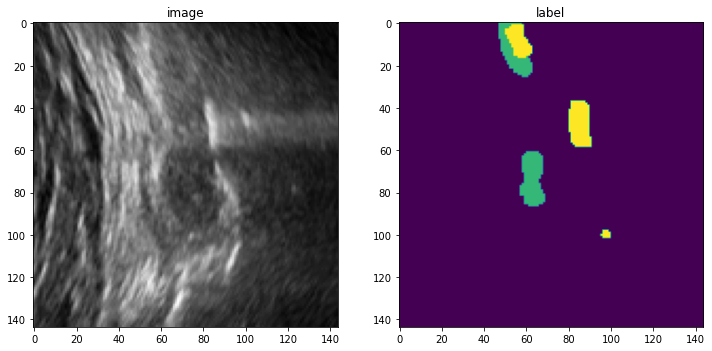

In [4]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()

In [5]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=0)
#train_ds = Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)


val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
#val_ds = Dataset(data=val_files, transform=val_transforms)
    
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

Loading dataset: 100%|███████████████████████████| 6/6 [00:00<00:00,  6.55it/s]


In [6]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [7]:
max_epochs = 2000
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=4)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=4)])

root_dir = "."

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        print("Step =", step)
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (144, 144, 16)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/2000
Step = 0
1/13, train_loss: 0.8602
Step = 1
2/13, train_loss: 0.8597
Step = 2
3/13, train_loss: 0.8486
Step = 3
4/13, train_loss: 0.8491
Step = 4
5/13, train_loss: 0.8573
Step = 5
6/13, train_loss: 0.8609
Step = 6
7/13, train_loss: 0.8508
Step = 7
8/13, train_loss: 0.8535
Step = 8
9/13, train_loss: 0.8481
Step = 9
10/13, train_loss: 0.8534
Step = 10
11/13, train_loss: 0.8456
Step = 11
12/13, train_loss: 0.8445
Step = 12
13/13, train_loss: 0.8473
epoch 1 average loss: 0.8522
----------
epoch 2/2000
Step = 0
1/13, train_loss: 0.8478
Step = 1
2/13, train_loss: 0.8446
Step = 2
3/13, train_loss: 0.8422
Step = 3
4/13, train_loss: 0.8412
Step = 4
5/13, train_loss: 0.8408
Step = 5
6/13, train_loss: 0.8393
Step = 6
7/13, train_loss: 0.8433
Step = 7
8/13, train_loss: 0.8459
Step = 8
9/13, train_loss: 0.8334
Step = 9
10/13, train_loss: 0.8348
Step = 10
11/13, train_loss: 0.8254
Step = 11
12/13, train_loss: 0.8245
Step = 12
13/13, train_loss: 0.8274
epoch 2 average loss: 0.8

12/13, train_loss: 0.7540
Step = 12
13/13, train_loss: 0.7246
epoch 15 average loss: 0.7419
----------
epoch 16/2000
Step = 0
1/13, train_loss: 0.7424
Step = 1
2/13, train_loss: 0.7479
Step = 2
3/13, train_loss: 0.7360
Step = 3
4/13, train_loss: 0.7278
Step = 4
5/13, train_loss: 0.7355
Step = 5
6/13, train_loss: 0.7385
Step = 6
7/13, train_loss: 0.7263
Step = 7
8/13, train_loss: 0.7204
Step = 8
9/13, train_loss: 0.7437
Step = 9
10/13, train_loss: 0.7472
Step = 10
11/13, train_loss: 0.7174
Step = 11
12/13, train_loss: 0.7340
Step = 12
13/13, train_loss: 0.7327
epoch 16 average loss: 0.7346
saved new best metric model
current epoch: 16 current mean dice: 0.2070
best mean dice: 0.2070 at epoch: 16
----------
epoch 17/2000
Step = 0
1/13, train_loss: 0.7130
Step = 1
2/13, train_loss: 0.7382
Step = 2
3/13, train_loss: 0.7186
Step = 3
4/13, train_loss: 0.7222
Step = 4
5/13, train_loss: 0.7316
Step = 5
6/13, train_loss: 0.7258
Step = 6
7/13, train_loss: 0.7323
Step = 7
8/13, train_loss: 0.7532

11/13, train_loss: 0.6511
Step = 11
12/13, train_loss: 0.5988
Step = 12
13/13, train_loss: 0.6096
epoch 30 average loss: 0.6201
current epoch: 30 current mean dice: 0.2915
best mean dice: 0.3174 at epoch: 26
----------
epoch 31/2000
Step = 0
1/13, train_loss: 0.5770
Step = 1
2/13, train_loss: 0.6061
Step = 2
3/13, train_loss: 0.5897
Step = 3
4/13, train_loss: 0.6369
Step = 4
5/13, train_loss: 0.6409
Step = 5
6/13, train_loss: 0.6443
Step = 6
7/13, train_loss: 0.6169
Step = 7
8/13, train_loss: 0.6427
Step = 8
9/13, train_loss: 0.5886
Step = 9
10/13, train_loss: 0.6348
Step = 10
11/13, train_loss: 0.6027
Step = 11
12/13, train_loss: 0.6265
Step = 12
13/13, train_loss: 0.5935
epoch 31 average loss: 0.6154
----------
epoch 32/2000
Step = 0
1/13, train_loss: 0.6244
Step = 1
2/13, train_loss: 0.6057
Step = 2
3/13, train_loss: 0.5971
Step = 3
4/13, train_loss: 0.5851
Step = 4
5/13, train_loss: 0.6063
Step = 5
6/13, train_loss: 0.5848
Step = 6
7/13, train_loss: 0.6381
Step = 7
8/13, train_loss

11/13, train_loss: 0.5604
Step = 11
12/13, train_loss: 0.5571
Step = 12
13/13, train_loss: 0.5658
epoch 45 average loss: 0.5527
----------
epoch 46/2000
Step = 0
1/13, train_loss: 0.5328
Step = 1
2/13, train_loss: 0.5469
Step = 2
3/13, train_loss: 0.5599
Step = 3
4/13, train_loss: 0.5193
Step = 4
5/13, train_loss: 0.5893
Step = 5
6/13, train_loss: 0.5195
Step = 6
7/13, train_loss: 0.5304
Step = 7
8/13, train_loss: 0.6303
Step = 8
9/13, train_loss: 0.5475
Step = 9
10/13, train_loss: 0.5198
Step = 10
11/13, train_loss: 0.5631
Step = 11
12/13, train_loss: 0.5157
Step = 12
13/13, train_loss: 0.5542
epoch 46 average loss: 0.5484
current epoch: 46 current mean dice: 0.2927
best mean dice: 0.3174 at epoch: 26
----------
epoch 47/2000
Step = 0
1/13, train_loss: 0.5820
Step = 1
2/13, train_loss: 0.5759
Step = 2
3/13, train_loss: 0.5378
Step = 3
4/13, train_loss: 0.5361
Step = 4
5/13, train_loss: 0.5389
Step = 5
6/13, train_loss: 0.5403
Step = 6
7/13, train_loss: 0.5340
Step = 7
8/13, train_loss

11/13, train_loss: 0.5092
Step = 11
12/13, train_loss: 0.4849
Step = 12
13/13, train_loss: 0.5227
epoch 60 average loss: 0.5179
current epoch: 60 current mean dice: 0.3465
best mean dice: 0.3923 at epoch: 58
----------
epoch 61/2000
Step = 0
1/13, train_loss: 0.4872
Step = 1
2/13, train_loss: 0.5093
Step = 2
3/13, train_loss: 0.4966
Step = 3
4/13, train_loss: 0.5258
Step = 4
5/13, train_loss: 0.5265
Step = 5
6/13, train_loss: 0.5530
Step = 6
7/13, train_loss: 0.5071
Step = 7
8/13, train_loss: 0.5194
Step = 8
9/13, train_loss: 0.4575
Step = 9
10/13, train_loss: 0.5810
Step = 10
11/13, train_loss: 0.4634
Step = 11
12/13, train_loss: 0.5250
Step = 12
13/13, train_loss: 0.4762
epoch 61 average loss: 0.5098
----------
epoch 62/2000
Step = 0
1/13, train_loss: 0.5328
Step = 1
2/13, train_loss: 0.4987
Step = 2
3/13, train_loss: 0.4574
Step = 3
4/13, train_loss: 0.4764
Step = 4
5/13, train_loss: 0.5031
Step = 5
6/13, train_loss: 0.4903
Step = 6
7/13, train_loss: 0.5408
Step = 7
8/13, train_loss

11/13, train_loss: 0.4610
Step = 11
12/13, train_loss: 0.4475
Step = 12
13/13, train_loss: 0.5103
epoch 75 average loss: 0.4760
----------
epoch 76/2000
Step = 0
1/13, train_loss: 0.4247
Step = 1
2/13, train_loss: 0.5367
Step = 2
3/13, train_loss: 0.4891
Step = 3
4/13, train_loss: 0.5000
Step = 4
5/13, train_loss: 0.4619
Step = 5
6/13, train_loss: 0.5010
Step = 6
7/13, train_loss: 0.4899
Step = 7
8/13, train_loss: 0.4408
Step = 8
9/13, train_loss: 0.4183
Step = 9
10/13, train_loss: 0.5058
Step = 10
11/13, train_loss: 0.5241
Step = 11
12/13, train_loss: 0.4737
Step = 12
13/13, train_loss: 0.4757
epoch 76 average loss: 0.4801
current epoch: 76 current mean dice: 0.3700
best mean dice: 0.3991 at epoch: 70
----------
epoch 77/2000
Step = 0
1/13, train_loss: 0.5214
Step = 1
2/13, train_loss: 0.5022
Step = 2
3/13, train_loss: 0.4260
Step = 3
4/13, train_loss: 0.4717
Step = 4
5/13, train_loss: 0.4999
Step = 5
6/13, train_loss: 0.4905
Step = 6
7/13, train_loss: 0.5082
Step = 7
8/13, train_loss

13/13, train_loss: 0.4542
epoch 90 average loss: 0.4560
current epoch: 90 current mean dice: 0.4101
best mean dice: 0.4156 at epoch: 80
----------
epoch 91/2000
Step = 0
1/13, train_loss: 0.4633
Step = 1
2/13, train_loss: 0.4369
Step = 2
3/13, train_loss: 0.4857
Step = 3
4/13, train_loss: 0.4373
Step = 4
5/13, train_loss: 0.4653
Step = 5
6/13, train_loss: 0.4648
Step = 6
7/13, train_loss: 0.4391
Step = 7
8/13, train_loss: 0.5153
Step = 8
9/13, train_loss: 0.4696
Step = 9
10/13, train_loss: 0.4589
Step = 10
11/13, train_loss: 0.4495
Step = 11
12/13, train_loss: 0.4254
Step = 12
13/13, train_loss: 0.4188
epoch 91 average loss: 0.4562
----------
epoch 92/2000
Step = 0
1/13, train_loss: 0.4442
Step = 1
2/13, train_loss: 0.4690
Step = 2
3/13, train_loss: 0.4543
Step = 3
4/13, train_loss: 0.4664
Step = 4
5/13, train_loss: 0.4290
Step = 5
6/13, train_loss: 0.4473
Step = 6
7/13, train_loss: 0.4682
Step = 7
8/13, train_loss: 0.4662
Step = 8
9/13, train_loss: 0.4468
Step = 9
10/13, train_loss: 0

12/13, train_loss: 0.4352
Step = 12
13/13, train_loss: 0.4659
epoch 105 average loss: 0.4477
----------
epoch 106/2000
Step = 0
1/13, train_loss: 0.3998
Step = 1
2/13, train_loss: 0.4268
Step = 2
3/13, train_loss: 0.4843
Step = 3
4/13, train_loss: 0.4689
Step = 4
5/13, train_loss: 0.4831
Step = 5
6/13, train_loss: 0.4438
Step = 6
7/13, train_loss: 0.4493
Step = 7
8/13, train_loss: 0.4715
Step = 8
9/13, train_loss: 0.4531
Step = 9
10/13, train_loss: 0.4655
Step = 10
11/13, train_loss: 0.4457
Step = 11
12/13, train_loss: 0.4461
Step = 12
13/13, train_loss: 0.4488
epoch 106 average loss: 0.4528
current epoch: 106 current mean dice: 0.3557
best mean dice: 0.4386 at epoch: 98
----------
epoch 107/2000
Step = 0
1/13, train_loss: 0.4672
Step = 1
2/13, train_loss: 0.4130
Step = 2
3/13, train_loss: 0.4052
Step = 3
4/13, train_loss: 0.4446
Step = 4
5/13, train_loss: 0.4012
Step = 5
6/13, train_loss: 0.4549
Step = 6
7/13, train_loss: 0.4111
Step = 7
8/13, train_loss: 0.4855
Step = 8
9/13, train_l

13/13, train_loss: 0.4410
epoch 120 average loss: 0.4360
current epoch: 120 current mean dice: 0.2218
best mean dice: 0.4405 at epoch: 116
----------
epoch 121/2000
Step = 0
1/13, train_loss: 0.4217
Step = 1
2/13, train_loss: 0.4567
Step = 2
3/13, train_loss: 0.4394
Step = 3
4/13, train_loss: 0.4464
Step = 4
5/13, train_loss: 0.4072
Step = 5
6/13, train_loss: 0.4023
Step = 6
7/13, train_loss: 0.3991
Step = 7
8/13, train_loss: 0.4223
Step = 8
9/13, train_loss: 0.4973
Step = 9
10/13, train_loss: 0.4398
Step = 10
11/13, train_loss: 0.4212
Step = 11
12/13, train_loss: 0.4430
Step = 12
13/13, train_loss: 0.4325
epoch 121 average loss: 0.4330
----------
epoch 122/2000
Step = 0
1/13, train_loss: 0.4142
Step = 1
2/13, train_loss: 0.4159
Step = 2
3/13, train_loss: 0.4231
Step = 3
4/13, train_loss: 0.4280
Step = 4
5/13, train_loss: 0.4338
Step = 5
6/13, train_loss: 0.4872
Step = 6
7/13, train_loss: 0.4243
Step = 7
8/13, train_loss: 0.4108
Step = 8
9/13, train_loss: 0.4556
Step = 9
10/13, train_l

12/13, train_loss: 0.4992
Step = 12
13/13, train_loss: 0.4341
epoch 135 average loss: 0.4299
----------
epoch 136/2000
Step = 0
1/13, train_loss: 0.4225
Step = 1
2/13, train_loss: 0.4963
Step = 2
3/13, train_loss: 0.3860
Step = 3
4/13, train_loss: 0.3766
Step = 4
5/13, train_loss: 0.3904
Step = 5
6/13, train_loss: 0.4106
Step = 6
7/13, train_loss: 0.3924
Step = 7
8/13, train_loss: 0.4672
Step = 8
9/13, train_loss: 0.4252
Step = 9
10/13, train_loss: 0.4170
Step = 10
11/13, train_loss: 0.4326
Step = 11
12/13, train_loss: 0.4252
Step = 12
13/13, train_loss: 0.4503
epoch 136 average loss: 0.4225
current epoch: 136 current mean dice: 0.2389
best mean dice: 0.4405 at epoch: 116
----------
epoch 137/2000
Step = 0
1/13, train_loss: 0.4373
Step = 1
2/13, train_loss: 0.4138
Step = 2
3/13, train_loss: 0.3968
Step = 3
4/13, train_loss: 0.4577
Step = 4
5/13, train_loss: 0.4287
Step = 5
6/13, train_loss: 0.4338
Step = 6
7/13, train_loss: 0.4528
Step = 7
8/13, train_loss: 0.4239
Step = 8
9/13, train_

13/13, train_loss: 0.4178
epoch 150 average loss: 0.4074
current epoch: 150 current mean dice: 0.3787
best mean dice: 0.4423 at epoch: 138
----------
epoch 151/2000
Step = 0
1/13, train_loss: 0.3840
Step = 1
2/13, train_loss: 0.4257
Step = 2
3/13, train_loss: 0.4460
Step = 3
4/13, train_loss: 0.3940
Step = 4
5/13, train_loss: 0.4020
Step = 5
6/13, train_loss: 0.3752
Step = 6
7/13, train_loss: 0.4079
Step = 7
8/13, train_loss: 0.3822
Step = 8
9/13, train_loss: 0.4165
Step = 9
10/13, train_loss: 0.3973
Step = 10
11/13, train_loss: 0.4084
Step = 11
12/13, train_loss: 0.4352
Step = 12
13/13, train_loss: 0.4213
epoch 151 average loss: 0.4074
----------
epoch 152/2000
Step = 0
1/13, train_loss: 0.4683
Step = 1
2/13, train_loss: 0.4000
Step = 2
3/13, train_loss: 0.3696
Step = 3
4/13, train_loss: 0.4610
Step = 4
5/13, train_loss: 0.4257
Step = 5
6/13, train_loss: 0.3976
Step = 6
7/13, train_loss: 0.3914
Step = 7
8/13, train_loss: 0.3989
Step = 8
9/13, train_loss: 0.3937
Step = 9
10/13, train_l

11/13, train_loss: 0.4242
Step = 11
12/13, train_loss: 0.4222
Step = 12
13/13, train_loss: 0.4341
epoch 165 average loss: 0.4105
----------
epoch 166/2000
Step = 0
1/13, train_loss: 0.3829
Step = 1
2/13, train_loss: 0.3914
Step = 2
3/13, train_loss: 0.4444
Step = 3
4/13, train_loss: 0.4068
Step = 4
5/13, train_loss: 0.3720
Step = 5
6/13, train_loss: 0.4254
Step = 6
7/13, train_loss: 0.4586
Step = 7
8/13, train_loss: 0.4302
Step = 8
9/13, train_loss: 0.3795
Step = 9
10/13, train_loss: 0.4109
Step = 10
11/13, train_loss: 0.4423
Step = 11
12/13, train_loss: 0.3984
Step = 12
13/13, train_loss: 0.4298
epoch 166 average loss: 0.4133
current epoch: 166 current mean dice: 0.4211
best mean dice: 0.4629 at epoch: 158
----------
epoch 167/2000
Step = 0
1/13, train_loss: 0.4114
Step = 1
2/13, train_loss: 0.4085
Step = 2
3/13, train_loss: 0.3804
Step = 3
4/13, train_loss: 0.4138
Step = 4
5/13, train_loss: 0.4413
Step = 5
6/13, train_loss: 0.3894
Step = 6
7/13, train_loss: 0.3979
Step = 7
8/13, trai

12/13, train_loss: 0.3788
Step = 12
13/13, train_loss: 0.3757
epoch 180 average loss: 0.4010
current epoch: 180 current mean dice: 0.3922
best mean dice: 0.4629 at epoch: 158
----------
epoch 181/2000
Step = 0
1/13, train_loss: 0.4418
Step = 1
2/13, train_loss: 0.3717
Step = 2
3/13, train_loss: 0.4027
Step = 3
4/13, train_loss: 0.4089
Step = 4
5/13, train_loss: 0.4118
Step = 5
6/13, train_loss: 0.3730
Step = 6
7/13, train_loss: 0.3983
Step = 7
8/13, train_loss: 0.3855
Step = 8
9/13, train_loss: 0.3950
Step = 9
10/13, train_loss: 0.4212
Step = 10
11/13, train_loss: 0.4207
Step = 11
12/13, train_loss: 0.4477
Step = 12
13/13, train_loss: 0.3928
epoch 181 average loss: 0.4055
----------
epoch 182/2000
Step = 0
1/13, train_loss: 0.4374
Step = 1
2/13, train_loss: 0.4621
Step = 2
3/13, train_loss: 0.4188
Step = 3
4/13, train_loss: 0.4350
Step = 4
5/13, train_loss: 0.3799
Step = 5
6/13, train_loss: 0.4051
Step = 6
7/13, train_loss: 0.3936
Step = 7
8/13, train_loss: 0.3776
Step = 8
9/13, train_

11/13, train_loss: 0.4022
Step = 11
12/13, train_loss: 0.3927
Step = 12
13/13, train_loss: 0.3662
epoch 195 average loss: 0.3995
----------
epoch 196/2000
Step = 0
1/13, train_loss: 0.4123
Step = 1
2/13, train_loss: 0.3965
Step = 2
3/13, train_loss: 0.4098
Step = 3
4/13, train_loss: 0.4032
Step = 4
5/13, train_loss: 0.3801
Step = 5
6/13, train_loss: 0.3973
Step = 6
7/13, train_loss: 0.3774
Step = 7
8/13, train_loss: 0.4063
Step = 8
9/13, train_loss: 0.3796
Step = 9
10/13, train_loss: 0.4081
Step = 10
11/13, train_loss: 0.3797
Step = 11
12/13, train_loss: 0.4486
Step = 12
13/13, train_loss: 0.4051
epoch 196 average loss: 0.4003
current epoch: 196 current mean dice: 0.3185
best mean dice: 0.4629 at epoch: 158
----------
epoch 197/2000
Step = 0
1/13, train_loss: 0.3831
Step = 1
2/13, train_loss: 0.3873
Step = 2
3/13, train_loss: 0.3694
Step = 3
4/13, train_loss: 0.3637
Step = 4
5/13, train_loss: 0.4063
Step = 5
6/13, train_loss: 0.3932
Step = 6
7/13, train_loss: 0.4468
Step = 7
8/13, trai

12/13, train_loss: 0.4072
Step = 12
13/13, train_loss: 0.4202
epoch 210 average loss: 0.4010
current epoch: 210 current mean dice: 0.3382
best mean dice: 0.4629 at epoch: 158
----------
epoch 211/2000
Step = 0
1/13, train_loss: 0.4153
Step = 1
2/13, train_loss: 0.3874
Step = 2
3/13, train_loss: 0.4395
Step = 3
4/13, train_loss: 0.4038
Step = 4
5/13, train_loss: 0.4148
Step = 5
6/13, train_loss: 0.3893
Step = 6
7/13, train_loss: 0.3740
Step = 7
8/13, train_loss: 0.4586
Step = 8
9/13, train_loss: 0.3923
Step = 9
10/13, train_loss: 0.3775
Step = 10
11/13, train_loss: 0.3866
Step = 11
12/13, train_loss: 0.4025
Step = 12
13/13, train_loss: 0.3987
epoch 211 average loss: 0.4031
----------
epoch 212/2000
Step = 0
1/13, train_loss: 0.4107
Step = 1
2/13, train_loss: 0.3725
Step = 2
3/13, train_loss: 0.3765
Step = 3
4/13, train_loss: 0.4175
Step = 4
5/13, train_loss: 0.3797
Step = 5
6/13, train_loss: 0.4089
Step = 6
7/13, train_loss: 0.4450
Step = 7
8/13, train_loss: 0.4107
Step = 8
9/13, train_

11/13, train_loss: 0.4382
Step = 11
12/13, train_loss: 0.4341
Step = 12
13/13, train_loss: 0.4028
epoch 225 average loss: 0.3953
----------
epoch 226/2000
Step = 0
1/13, train_loss: 0.3696
Step = 1
2/13, train_loss: 0.3927
Step = 2
3/13, train_loss: 0.3953
Step = 3
4/13, train_loss: 0.3612
Step = 4
5/13, train_loss: 0.3667
Step = 5
6/13, train_loss: 0.3955
Step = 6
7/13, train_loss: 0.4029
Step = 7
8/13, train_loss: 0.3813
Step = 8
9/13, train_loss: 0.3774
Step = 9
10/13, train_loss: 0.4209
Step = 10
11/13, train_loss: 0.3961
Step = 11
12/13, train_loss: 0.4142
Step = 12
13/13, train_loss: 0.3697
epoch 226 average loss: 0.3879
current epoch: 226 current mean dice: 0.4064
best mean dice: 0.4629 at epoch: 158
----------
epoch 227/2000
Step = 0
1/13, train_loss: 0.3940
Step = 1
2/13, train_loss: 0.3811
Step = 2
3/13, train_loss: 0.4154
Step = 3
4/13, train_loss: 0.3456
Step = 4
5/13, train_loss: 0.4030
Step = 5
6/13, train_loss: 0.3918
Step = 6
7/13, train_loss: 0.3530
Step = 7
8/13, trai

12/13, train_loss: 0.3796
Step = 12
13/13, train_loss: 0.3853
epoch 240 average loss: 0.3853
current epoch: 240 current mean dice: 0.3883
best mean dice: 0.4629 at epoch: 158
----------
epoch 241/2000
Step = 0
1/13, train_loss: 0.4284
Step = 1
2/13, train_loss: 0.3534
Step = 2
3/13, train_loss: 0.3537
Step = 3
4/13, train_loss: 0.4068
Step = 4
5/13, train_loss: 0.4231
Step = 5
6/13, train_loss: 0.3852
Step = 6
7/13, train_loss: 0.3779
Step = 7
8/13, train_loss: 0.4336
Step = 8
9/13, train_loss: 0.3586
Step = 9
10/13, train_loss: 0.4139
Step = 10
11/13, train_loss: 0.4202
Step = 11
12/13, train_loss: 0.3508
Step = 12
13/13, train_loss: 0.3662
epoch 241 average loss: 0.3902
----------
epoch 242/2000
Step = 0
1/13, train_loss: 0.4001
Step = 1
2/13, train_loss: 0.3845
Step = 2
3/13, train_loss: 0.3692
Step = 3
4/13, train_loss: 0.4192
Step = 4
5/13, train_loss: 0.3482
Step = 5
6/13, train_loss: 0.4198
Step = 6
7/13, train_loss: 0.3841
Step = 7
8/13, train_loss: 0.4163
Step = 8
9/13, train_

11/13, train_loss: 0.3601
Step = 11
12/13, train_loss: 0.4199
Step = 12
13/13, train_loss: 0.3941
epoch 255 average loss: 0.3809
----------
epoch 256/2000
Step = 0
1/13, train_loss: 0.3552
Step = 1
2/13, train_loss: 0.3885
Step = 2
3/13, train_loss: 0.3820
Step = 3
4/13, train_loss: 0.3850
Step = 4
5/13, train_loss: 0.3786
Step = 5
6/13, train_loss: 0.3774
Step = 6
7/13, train_loss: 0.3856
Step = 7
8/13, train_loss: 0.3958
Step = 8
9/13, train_loss: 0.3813
Step = 9
10/13, train_loss: 0.4135
Step = 10
11/13, train_loss: 0.3852
Step = 11
12/13, train_loss: 0.3776
Step = 12
13/13, train_loss: 0.4007
epoch 256 average loss: 0.3851
current epoch: 256 current mean dice: 0.3600
best mean dice: 0.4629 at epoch: 158
----------
epoch 257/2000
Step = 0
1/13, train_loss: 0.3621
Step = 1
2/13, train_loss: 0.3937
Step = 2
3/13, train_loss: 0.4221
Step = 3
4/13, train_loss: 0.3636
Step = 4
5/13, train_loss: 0.4236
Step = 5
6/13, train_loss: 0.3667
Step = 6
7/13, train_loss: 0.3952
Step = 7
8/13, trai

12/13, train_loss: 0.3772
Step = 12
13/13, train_loss: 0.4355
epoch 270 average loss: 0.3827
current epoch: 270 current mean dice: 0.3718
best mean dice: 0.4629 at epoch: 158
----------
epoch 271/2000
Step = 0
1/13, train_loss: 0.3672
Step = 1
2/13, train_loss: 0.3888
Step = 2
3/13, train_loss: 0.3558
Step = 3
4/13, train_loss: 0.4102
Step = 4
5/13, train_loss: 0.4018
Step = 5
6/13, train_loss: 0.3620
Step = 6
7/13, train_loss: 0.3647
Step = 7
8/13, train_loss: 0.3959
Step = 8
9/13, train_loss: 0.4020
Step = 9
10/13, train_loss: 0.3552
Step = 10
11/13, train_loss: 0.3630
Step = 11
12/13, train_loss: 0.4133
Step = 12
13/13, train_loss: 0.4019
epoch 271 average loss: 0.3832
----------
epoch 272/2000
Step = 0
1/13, train_loss: 0.3675
Step = 1
2/13, train_loss: 0.4012
Step = 2
3/13, train_loss: 0.3651
Step = 3
4/13, train_loss: 0.4132
Step = 4
5/13, train_loss: 0.3654
Step = 5
6/13, train_loss: 0.3748
Step = 6
7/13, train_loss: 0.4045
Step = 7
8/13, train_loss: 0.3737
Step = 8
9/13, train_

11/13, train_loss: 0.3509
Step = 11
12/13, train_loss: 0.3683
Step = 12
13/13, train_loss: 0.3897
epoch 285 average loss: 0.3778
----------
epoch 286/2000
Step = 0
1/13, train_loss: 0.4016
Step = 1
2/13, train_loss: 0.3802
Step = 2
3/13, train_loss: 0.4347
Step = 3
4/13, train_loss: 0.3408
Step = 4
5/13, train_loss: 0.3607
Step = 5
6/13, train_loss: 0.3534
Step = 6
7/13, train_loss: 0.3481
Step = 7
8/13, train_loss: 0.3804
Step = 8
9/13, train_loss: 0.3671
Step = 9
10/13, train_loss: 0.3965
Step = 10
11/13, train_loss: 0.3894
Step = 11
12/13, train_loss: 0.4360
Step = 12
13/13, train_loss: 0.4084
epoch 286 average loss: 0.3844
current epoch: 286 current mean dice: 0.3368
best mean dice: 0.4629 at epoch: 158
----------
epoch 287/2000
Step = 0
1/13, train_loss: 0.3855
Step = 1
2/13, train_loss: 0.3804
Step = 2
3/13, train_loss: 0.3650
Step = 3
4/13, train_loss: 0.3605
Step = 4
5/13, train_loss: 0.3915
Step = 5
6/13, train_loss: 0.3739
Step = 6
7/13, train_loss: 0.3397
Step = 7
8/13, trai

12/13, train_loss: 0.4004
Step = 12
13/13, train_loss: 0.3529
epoch 300 average loss: 0.3800
current epoch: 300 current mean dice: 0.3878
best mean dice: 0.4629 at epoch: 158
----------
epoch 301/2000
Step = 0
1/13, train_loss: 0.3737
Step = 1
2/13, train_loss: 0.3787
Step = 2
3/13, train_loss: 0.3730
Step = 3
4/13, train_loss: 0.3667
Step = 4
5/13, train_loss: 0.4008
Step = 5
6/13, train_loss: 0.3727
Step = 6
7/13, train_loss: 0.3691
Step = 7
8/13, train_loss: 0.4126
Step = 8
9/13, train_loss: 0.3792
Step = 9
10/13, train_loss: 0.3768
Step = 10
11/13, train_loss: 0.3927
Step = 11
12/13, train_loss: 0.3638
Step = 12
13/13, train_loss: 0.3513
epoch 301 average loss: 0.3778
----------
epoch 302/2000
Step = 0
1/13, train_loss: 0.3868
Step = 1
2/13, train_loss: 0.3675
Step = 2
3/13, train_loss: 0.4004
Step = 3
4/13, train_loss: 0.4069
Step = 4
5/13, train_loss: 0.3727
Step = 5
6/13, train_loss: 0.3702
Step = 6
7/13, train_loss: 0.3857
Step = 7
8/13, train_loss: 0.3589
Step = 8
9/13, train_

11/13, train_loss: 0.4154
Step = 11
12/13, train_loss: 0.3687
Step = 12
13/13, train_loss: 0.3921
epoch 315 average loss: 0.3749
----------
epoch 316/2000
Step = 0
1/13, train_loss: 0.3805
Step = 1
2/13, train_loss: 0.3842
Step = 2
3/13, train_loss: 0.3853
Step = 3
4/13, train_loss: 0.3613
Step = 4
5/13, train_loss: 0.3545
Step = 5
6/13, train_loss: 0.3737
Step = 6
7/13, train_loss: 0.3528
Step = 7
8/13, train_loss: 0.3579
Step = 8
9/13, train_loss: 0.3717
Step = 9
10/13, train_loss: 0.3644
Step = 10
11/13, train_loss: 0.3848
Step = 11
12/13, train_loss: 0.3921
Step = 12
13/13, train_loss: 0.4077
epoch 316 average loss: 0.3747
current epoch: 316 current mean dice: 0.3345
best mean dice: 0.4629 at epoch: 158
----------
epoch 317/2000
Step = 0
1/13, train_loss: 0.4019
Step = 1
2/13, train_loss: 0.3636
Step = 2
3/13, train_loss: 0.3695
Step = 3
4/13, train_loss: 0.3572
Step = 4
5/13, train_loss: 0.3786
Step = 5
6/13, train_loss: 0.3883
Step = 6
7/13, train_loss: 0.3706
Step = 7
8/13, trai

12/13, train_loss: 0.3698
Step = 12
13/13, train_loss: 0.4217
epoch 330 average loss: 0.3735
current epoch: 330 current mean dice: 0.3671
best mean dice: 0.4629 at epoch: 158
----------
epoch 331/2000
Step = 0
1/13, train_loss: 0.3880
Step = 1
2/13, train_loss: 0.3938
Step = 2
3/13, train_loss: 0.3624
Step = 3
4/13, train_loss: 0.3545
Step = 4
5/13, train_loss: 0.3824
Step = 5
6/13, train_loss: 0.3511
Step = 6
7/13, train_loss: 0.3699
Step = 7
8/13, train_loss: 0.4256
Step = 8
9/13, train_loss: 0.3478
Step = 9
10/13, train_loss: 0.3401
Step = 10
11/13, train_loss: 0.3656
Step = 11
12/13, train_loss: 0.3767
Step = 12
13/13, train_loss: 0.3957
epoch 331 average loss: 0.3734
----------
epoch 332/2000
Step = 0
1/13, train_loss: 0.3789
Step = 1
2/13, train_loss: 0.3626
Step = 2
3/13, train_loss: 0.3398
Step = 3
4/13, train_loss: 0.3874
Step = 4
5/13, train_loss: 0.3687
Step = 5
6/13, train_loss: 0.4088
Step = 6
7/13, train_loss: 0.3996
Step = 7
8/13, train_loss: 0.3817
Step = 8
9/13, train_

11/13, train_loss: 0.3988
Step = 11
12/13, train_loss: 0.3561
Step = 12
13/13, train_loss: 0.3635
epoch 345 average loss: 0.3672
----------
epoch 346/2000
Step = 0
1/13, train_loss: 0.3607
Step = 1
2/13, train_loss: 0.3477
Step = 2
3/13, train_loss: 0.3547
Step = 3
4/13, train_loss: 0.3549
Step = 4
5/13, train_loss: 0.3859
Step = 5
6/13, train_loss: 0.3842
Step = 6
7/13, train_loss: 0.3785
Step = 7
8/13, train_loss: 0.3851
Step = 8
9/13, train_loss: 0.3872
Step = 9
10/13, train_loss: 0.3571
Step = 10
11/13, train_loss: 0.3636
Step = 11
12/13, train_loss: 0.3566
Step = 12
13/13, train_loss: 0.3755
epoch 346 average loss: 0.3686
current epoch: 346 current mean dice: 0.3638
best mean dice: 0.4629 at epoch: 158
----------
epoch 347/2000
Step = 0
1/13, train_loss: 0.3791
Step = 1
2/13, train_loss: 0.3914
Step = 2
3/13, train_loss: 0.3464
Step = 3
4/13, train_loss: 0.4236
Step = 4
5/13, train_loss: 0.3907
Step = 5
6/13, train_loss: 0.3826
Step = 6
7/13, train_loss: 0.3568
Step = 7
8/13, trai

12/13, train_loss: 0.3568
Step = 12
13/13, train_loss: 0.3679
epoch 360 average loss: 0.3706
current epoch: 360 current mean dice: 0.4014
best mean dice: 0.4629 at epoch: 158
----------
epoch 361/2000
Step = 0
1/13, train_loss: 0.3496
Step = 1
2/13, train_loss: 0.3530
Step = 2
3/13, train_loss: 0.3528
Step = 3
4/13, train_loss: 0.3611
Step = 4
5/13, train_loss: 0.3613
Step = 5
6/13, train_loss: 0.3631
Step = 6
7/13, train_loss: 0.4248
Step = 7
8/13, train_loss: 0.3597
Step = 8
9/13, train_loss: 0.4080
Step = 9
10/13, train_loss: 0.3534
Step = 10
11/13, train_loss: 0.3829
Step = 11
12/13, train_loss: 0.3739
Step = 12
13/13, train_loss: 0.4137
epoch 361 average loss: 0.3736
----------
epoch 362/2000
Step = 0
1/13, train_loss: 0.3679
Step = 1
2/13, train_loss: 0.3810
Step = 2
3/13, train_loss: 0.3645
Step = 3
4/13, train_loss: 0.3694
Step = 4
5/13, train_loss: 0.4094
Step = 5
6/13, train_loss: 0.3670
Step = 6
7/13, train_loss: 0.3501
Step = 7
8/13, train_loss: 0.3763
Step = 8
9/13, train_

11/13, train_loss: 0.3504
Step = 11
12/13, train_loss: 0.3520
Step = 12
13/13, train_loss: 0.4035
epoch 375 average loss: 0.3640
----------
epoch 376/2000
Step = 0
1/13, train_loss: 0.3780
Step = 1
2/13, train_loss: 0.3327
Step = 2
3/13, train_loss: 0.3841
Step = 3
4/13, train_loss: 0.3615
Step = 4
5/13, train_loss: 0.3497
Step = 5
6/13, train_loss: 0.3868
Step = 6
7/13, train_loss: 0.3885
Step = 7
8/13, train_loss: 0.3456
Step = 8
9/13, train_loss: 0.3467
Step = 9
10/13, train_loss: 0.3783
Step = 10
11/13, train_loss: 0.3445
Step = 11
12/13, train_loss: 0.3748
Step = 12
13/13, train_loss: 0.3562
epoch 376 average loss: 0.3637
current epoch: 376 current mean dice: 0.4118
best mean dice: 0.4629 at epoch: 158
----------
epoch 377/2000
Step = 0
1/13, train_loss: 0.3485
Step = 1
2/13, train_loss: 0.3723
Step = 2
3/13, train_loss: 0.3418
Step = 3
4/13, train_loss: 0.3641
Step = 4
5/13, train_loss: 0.3732
Step = 5
6/13, train_loss: 0.3924
Step = 6
7/13, train_loss: 0.3658
Step = 7
8/13, trai

12/13, train_loss: 0.3662
Step = 12
13/13, train_loss: 0.3557
epoch 390 average loss: 0.3651
current epoch: 390 current mean dice: 0.3676
best mean dice: 0.4629 at epoch: 158
----------
epoch 391/2000
Step = 0
1/13, train_loss: 0.3447
Step = 1
2/13, train_loss: 0.3380
Step = 2
3/13, train_loss: 0.3849
Step = 3
4/13, train_loss: 0.4004
Step = 4
5/13, train_loss: 0.3437
Step = 5
6/13, train_loss: 0.3914
Step = 6
7/13, train_loss: 0.3597
Step = 7
8/13, train_loss: 0.3415
Step = 8
9/13, train_loss: 0.3867
Step = 9
10/13, train_loss: 0.3549
Step = 10
11/13, train_loss: 0.3623
Step = 11
12/13, train_loss: 0.3562
Step = 12
13/13, train_loss: 0.4114
epoch 391 average loss: 0.3674
----------
epoch 392/2000
Step = 0
1/13, train_loss: 0.3497
Step = 1
2/13, train_loss: 0.3659
Step = 2
3/13, train_loss: 0.3503
Step = 3
4/13, train_loss: 0.3858
Step = 4
5/13, train_loss: 0.3811
Step = 5
6/13, train_loss: 0.3876
Step = 6
7/13, train_loss: 0.3915
Step = 7
8/13, train_loss: 0.3420
Step = 8
9/13, train_

11/13, train_loss: 0.4075
Step = 11
12/13, train_loss: 0.3618
Step = 12
13/13, train_loss: 0.3501
epoch 405 average loss: 0.3682
----------
epoch 406/2000
Step = 0
1/13, train_loss: 0.3496
Step = 1
2/13, train_loss: 0.3839
Step = 2
3/13, train_loss: 0.3926
Step = 3
4/13, train_loss: 0.3664
Step = 4
5/13, train_loss: 0.3804
Step = 5
6/13, train_loss: 0.3574
Step = 6
7/13, train_loss: 0.3594
Step = 7
8/13, train_loss: 0.3654
Step = 8
9/13, train_loss: 0.3529
Step = 9
10/13, train_loss: 0.3671
Step = 10
11/13, train_loss: 0.3512
Step = 11
12/13, train_loss: 0.3905
Step = 12
13/13, train_loss: 0.3872
epoch 406 average loss: 0.3695
current epoch: 406 current mean dice: 0.3510
best mean dice: 0.4629 at epoch: 158
----------
epoch 407/2000
Step = 0
1/13, train_loss: 0.3522
Step = 1
2/13, train_loss: 0.3532
Step = 2
3/13, train_loss: 0.3731
Step = 3
4/13, train_loss: 0.3932
Step = 4
5/13, train_loss: 0.3694
Step = 5
6/13, train_loss: 0.3716
Step = 6
7/13, train_loss: 0.3476
Step = 7
8/13, trai

12/13, train_loss: 0.3430
Step = 12
13/13, train_loss: 0.3487
epoch 420 average loss: 0.3686
current epoch: 420 current mean dice: 0.3959
best mean dice: 0.4629 at epoch: 158
----------
epoch 421/2000
Step = 0
1/13, train_loss: 0.3796
Step = 1
2/13, train_loss: 0.3715
Step = 2
3/13, train_loss: 0.3493
Step = 3
4/13, train_loss: 0.3545
Step = 4
5/13, train_loss: 0.3603
Step = 5
6/13, train_loss: 0.3545
Step = 6
7/13, train_loss: 0.3961
Step = 7
8/13, train_loss: 0.3680
Step = 8
9/13, train_loss: 0.3553
Step = 9
10/13, train_loss: 0.3649
Step = 10
11/13, train_loss: 0.3645
Step = 11
12/13, train_loss: 0.3506
Step = 12
13/13, train_loss: 0.3720
epoch 421 average loss: 0.3647
----------
epoch 422/2000
Step = 0
1/13, train_loss: 0.3490
Step = 1
2/13, train_loss: 0.3798
Step = 2
3/13, train_loss: 0.3669
Step = 3
4/13, train_loss: 0.3727
Step = 4
5/13, train_loss: 0.3497
Step = 5
6/13, train_loss: 0.3265
Step = 6
7/13, train_loss: 0.3827
Step = 7
8/13, train_loss: 0.3683
Step = 8
9/13, train_

11/13, train_loss: 0.3372
Step = 11
12/13, train_loss: 0.4012
Step = 12
13/13, train_loss: 0.3341
epoch 435 average loss: 0.3602
----------
epoch 436/2000
Step = 0
1/13, train_loss: 0.3378
Step = 1
2/13, train_loss: 0.3452
Step = 2
3/13, train_loss: 0.3396
Step = 3
4/13, train_loss: 0.3424
Step = 4
5/13, train_loss: 0.3621
Step = 5
6/13, train_loss: 0.3800
Step = 6
7/13, train_loss: 0.3516
Step = 7
8/13, train_loss: 0.3553
Step = 8
9/13, train_loss: 0.3857
Step = 9
10/13, train_loss: 0.3842
Step = 10
11/13, train_loss: 0.3696
Step = 11
12/13, train_loss: 0.3442
Step = 12
13/13, train_loss: 0.3699
epoch 436 average loss: 0.3590
current epoch: 436 current mean dice: 0.3062
best mean dice: 0.4629 at epoch: 158
----------
epoch 437/2000
Step = 0
1/13, train_loss: 0.3565
Step = 1
2/13, train_loss: 0.3674
Step = 2
3/13, train_loss: 0.3500
Step = 3
4/13, train_loss: 0.3595
Step = 4
5/13, train_loss: 0.3347
Step = 5
6/13, train_loss: 0.3846
Step = 6
7/13, train_loss: 0.3599
Step = 7
8/13, trai

12/13, train_loss: 0.3378
Step = 12
13/13, train_loss: 0.3563
epoch 450 average loss: 0.3609
current epoch: 450 current mean dice: 0.3508
best mean dice: 0.4629 at epoch: 158
----------
epoch 451/2000
Step = 0
1/13, train_loss: 0.3396
Step = 1
2/13, train_loss: 0.3440
Step = 2
3/13, train_loss: 0.3992
Step = 3
4/13, train_loss: 0.3474
Step = 4
5/13, train_loss: 0.3345
Step = 5
6/13, train_loss: 0.3601
Step = 6
7/13, train_loss: 0.3581
Step = 7
8/13, train_loss: 0.3605
Step = 8
9/13, train_loss: 0.3633
Step = 9
10/13, train_loss: 0.3538
Step = 10
11/13, train_loss: 0.3550
Step = 11
12/13, train_loss: 0.3599
Step = 12
13/13, train_loss: 0.3603
epoch 451 average loss: 0.3566
----------
epoch 452/2000
Step = 0
1/13, train_loss: 0.3576
Step = 1
2/13, train_loss: 0.3469
Step = 2
3/13, train_loss: 0.3459
Step = 3
4/13, train_loss: 0.4131
Step = 4
5/13, train_loss: 0.3782
Step = 5
6/13, train_loss: 0.3467
Step = 6
7/13, train_loss: 0.3553
Step = 7
8/13, train_loss: 0.3486
Step = 8
9/13, train_

11/13, train_loss: 0.3768
Step = 11
12/13, train_loss: 0.3630
Step = 12
13/13, train_loss: 0.3597
epoch 465 average loss: 0.3630
----------
epoch 466/2000
Step = 0
1/13, train_loss: 0.3302
Step = 1
2/13, train_loss: 0.3664
Step = 2
3/13, train_loss: 0.3849
Step = 3
4/13, train_loss: 0.4127
Step = 4
5/13, train_loss: 0.3487
Step = 5
6/13, train_loss: 0.3544
Step = 6
7/13, train_loss: 0.3734
Step = 7
8/13, train_loss: 0.3636
Step = 8
9/13, train_loss: 0.3794
Step = 9
10/13, train_loss: 0.3347
Step = 10
11/13, train_loss: 0.3664
Step = 11
12/13, train_loss: 0.3532
Step = 12
13/13, train_loss: 0.3524
epoch 466 average loss: 0.3631
current epoch: 466 current mean dice: 0.3538
best mean dice: 0.4629 at epoch: 158
----------
epoch 467/2000
Step = 0
1/13, train_loss: 0.3481
Step = 1
2/13, train_loss: 0.3511
Step = 2
3/13, train_loss: 0.3823
Step = 3
4/13, train_loss: 0.3755
Step = 4
5/13, train_loss: 0.3526
Step = 5
6/13, train_loss: 0.3441
Step = 6
7/13, train_loss: 0.3824
Step = 7
8/13, trai

12/13, train_loss: 0.3702
Step = 12
13/13, train_loss: 0.3424
epoch 480 average loss: 0.3584
current epoch: 480 current mean dice: 0.3747
best mean dice: 0.4629 at epoch: 158
----------
epoch 481/2000
Step = 0
1/13, train_loss: 0.3463
Step = 1
2/13, train_loss: 0.3815
Step = 2
3/13, train_loss: 0.3643
Step = 3
4/13, train_loss: 0.3397
Step = 4
5/13, train_loss: 0.3443
Step = 5
6/13, train_loss: 0.3672
Step = 6
7/13, train_loss: 0.3576
Step = 7
8/13, train_loss: 0.3802
Step = 8
9/13, train_loss: 0.3414
Step = 9
10/13, train_loss: 0.3571
Step = 10
11/13, train_loss: 0.3709
Step = 11
12/13, train_loss: 0.3496
Step = 12
13/13, train_loss: 0.3488
epoch 481 average loss: 0.3576
----------
epoch 482/2000
Step = 0
1/13, train_loss: 0.3674
Step = 1
2/13, train_loss: 0.3473
Step = 2
3/13, train_loss: 0.3500
Step = 3
4/13, train_loss: 0.3834
Step = 4
5/13, train_loss: 0.4019
Step = 5
6/13, train_loss: 0.3616
Step = 6
7/13, train_loss: 0.3525
Step = 7
8/13, train_loss: 0.3584
Step = 8
9/13, train_

11/13, train_loss: 0.3792
Step = 11
12/13, train_loss: 0.3559
Step = 12
13/13, train_loss: 0.3376
epoch 495 average loss: 0.3563
----------
epoch 496/2000
Step = 0
1/13, train_loss: 0.3535
Step = 1
2/13, train_loss: 0.3446
Step = 2
3/13, train_loss: 0.3482
Step = 3
4/13, train_loss: 0.3448
Step = 4
5/13, train_loss: 0.3425
Step = 5
6/13, train_loss: 0.3757
Step = 6
7/13, train_loss: 0.3463
Step = 7
8/13, train_loss: 0.3676
Step = 8
9/13, train_loss: 0.3873
Step = 9
10/13, train_loss: 0.3379
Step = 10
11/13, train_loss: 0.3580
Step = 11
12/13, train_loss: 0.3675
Step = 12
13/13, train_loss: 0.3539
epoch 496 average loss: 0.3560
current epoch: 496 current mean dice: 0.3748
best mean dice: 0.4629 at epoch: 158
----------
epoch 497/2000
Step = 0
1/13, train_loss: 0.3327
Step = 1
2/13, train_loss: 0.3699
Step = 2
3/13, train_loss: 0.3413
Step = 3
4/13, train_loss: 0.3422
Step = 4
5/13, train_loss: 0.3394
Step = 5
6/13, train_loss: 0.3603
Step = 6
7/13, train_loss: 0.3566
Step = 7
8/13, trai

12/13, train_loss: 0.3476
Step = 12
13/13, train_loss: 0.3288
epoch 510 average loss: 0.3586
current epoch: 510 current mean dice: 0.3072
best mean dice: 0.4629 at epoch: 158
----------
epoch 511/2000
Step = 0
1/13, train_loss: 0.3369
Step = 1
2/13, train_loss: 0.3501
Step = 2
3/13, train_loss: 0.3443
Step = 3
4/13, train_loss: 0.3381
Step = 4
5/13, train_loss: 0.3635
Step = 5
6/13, train_loss: 0.3679
Step = 6
7/13, train_loss: 0.3552
Step = 7
8/13, train_loss: 0.3630
Step = 8
9/13, train_loss: 0.3782
Step = 9
10/13, train_loss: 0.3744
Step = 10
11/13, train_loss: 0.3558
Step = 11
12/13, train_loss: 0.3573
Step = 12
13/13, train_loss: 0.3569
epoch 511 average loss: 0.3570
----------
epoch 512/2000
Step = 0
1/13, train_loss: 0.3491
Step = 1
2/13, train_loss: 0.3869
Step = 2
3/13, train_loss: 0.3392
Step = 3
4/13, train_loss: 0.3570
Step = 4
5/13, train_loss: 0.3506
Step = 5
6/13, train_loss: 0.3484
Step = 6
7/13, train_loss: 0.3569
Step = 7
8/13, train_loss: 0.3609
Step = 8
9/13, train_

11/13, train_loss: 0.4091
Step = 11
12/13, train_loss: 0.3474
Step = 12
13/13, train_loss: 0.3539
epoch 525 average loss: 0.3554
----------
epoch 526/2000
Step = 0
1/13, train_loss: 0.3472
Step = 1
2/13, train_loss: 0.3798
Step = 2
3/13, train_loss: 0.3778
Step = 3
4/13, train_loss: 0.3600
Step = 4
5/13, train_loss: 0.3625
Step = 5
6/13, train_loss: 0.3444
Step = 6
7/13, train_loss: 0.3271
Step = 7
8/13, train_loss: 0.3561
Step = 8
9/13, train_loss: 0.3241
Step = 9
10/13, train_loss: 0.3588
Step = 10
11/13, train_loss: 0.3435
Step = 11
12/13, train_loss: 0.3490
Step = 12
13/13, train_loss: 0.3247
epoch 526 average loss: 0.3504
current epoch: 526 current mean dice: 0.3663
best mean dice: 0.4629 at epoch: 158
----------
epoch 527/2000
Step = 0
1/13, train_loss: 0.3603
Step = 1
2/13, train_loss: 0.3946
Step = 2
3/13, train_loss: 0.3967
Step = 3
4/13, train_loss: 0.3432
Step = 4
5/13, train_loss: 0.3797
Step = 5
6/13, train_loss: 0.3621
Step = 6
7/13, train_loss: 0.3597
Step = 7
8/13, trai

12/13, train_loss: 0.3611
Step = 12
13/13, train_loss: 0.3787
epoch 540 average loss: 0.3574
current epoch: 540 current mean dice: 0.3654
best mean dice: 0.4629 at epoch: 158
----------
epoch 541/2000
Step = 0
1/13, train_loss: 0.3793
Step = 1
2/13, train_loss: 0.3479
Step = 2
3/13, train_loss: 0.3501
Step = 3
4/13, train_loss: 0.3872
Step = 4
5/13, train_loss: 0.3572
Step = 5
6/13, train_loss: 0.3515
Step = 6
7/13, train_loss: 0.3325
Step = 7
8/13, train_loss: 0.3787
Step = 8
9/13, train_loss: 0.3423
Step = 9
10/13, train_loss: 0.3522
Step = 10
11/13, train_loss: 0.3709
Step = 11
12/13, train_loss: 0.3459
Step = 12
13/13, train_loss: 0.3610
epoch 541 average loss: 0.3582
----------
epoch 542/2000
Step = 0
1/13, train_loss: 0.3751
Step = 1
2/13, train_loss: 0.3652
Step = 2
3/13, train_loss: 0.3302
Step = 3
4/13, train_loss: 0.3471
Step = 4
5/13, train_loss: 0.3549
Step = 5
6/13, train_loss: 0.3799
Step = 6
7/13, train_loss: 0.3482
Step = 7
8/13, train_loss: 0.3541
Step = 8
9/13, train_

11/13, train_loss: 0.3567
Step = 11
12/13, train_loss: 0.3345
Step = 12
13/13, train_loss: 0.3405
epoch 555 average loss: 0.3461
----------
epoch 556/2000
Step = 0
1/13, train_loss: 0.3587
Step = 1
2/13, train_loss: 0.3476
Step = 2
3/13, train_loss: 0.3622
Step = 3
4/13, train_loss: 0.3613
Step = 4
5/13, train_loss: 0.3357
Step = 5
6/13, train_loss: 0.3439
Step = 6
7/13, train_loss: 0.3511
Step = 7
8/13, train_loss: 0.3238
Step = 8
9/13, train_loss: 0.3615
Step = 9
10/13, train_loss: 0.3326
Step = 10
11/13, train_loss: 0.3515
Step = 11
12/13, train_loss: 0.3252
Step = 12
13/13, train_loss: 0.3419
epoch 556 average loss: 0.3459
current epoch: 556 current mean dice: 0.3416
best mean dice: 0.4629 at epoch: 158
----------
epoch 557/2000
Step = 0
1/13, train_loss: 0.3993
Step = 1
2/13, train_loss: 0.3283
Step = 2
3/13, train_loss: 0.3550
Step = 3
4/13, train_loss: 0.3667
Step = 4
5/13, train_loss: 0.3346
Step = 5
6/13, train_loss: 0.3459
Step = 6
7/13, train_loss: 0.3418
Step = 7
8/13, trai

12/13, train_loss: 0.3375
Step = 12
13/13, train_loss: 0.3497
epoch 570 average loss: 0.3528
current epoch: 570 current mean dice: 0.3955
best mean dice: 0.4629 at epoch: 158
----------
epoch 571/2000
Step = 0
1/13, train_loss: 0.3525
Step = 1
2/13, train_loss: 0.3428
Step = 2
3/13, train_loss: 0.3655
Step = 3
4/13, train_loss: 0.3738
Step = 4
5/13, train_loss: 0.3473
Step = 5
6/13, train_loss: 0.3341
Step = 6
7/13, train_loss: 0.3511
Step = 7
8/13, train_loss: 0.3492
Step = 8
9/13, train_loss: 0.3833
Step = 9
10/13, train_loss: 0.3655
Step = 10
11/13, train_loss: 0.3399
Step = 11
12/13, train_loss: 0.3298
Step = 12
13/13, train_loss: 0.3333
epoch 571 average loss: 0.3514
----------
epoch 572/2000
Step = 0
1/13, train_loss: 0.3661
Step = 1
2/13, train_loss: 0.3595
Step = 2
3/13, train_loss: 0.3369
Step = 3
4/13, train_loss: 0.3519
Step = 4
5/13, train_loss: 0.3558
Step = 5
6/13, train_loss: 0.3553
Step = 6
7/13, train_loss: 0.3401
Step = 7
8/13, train_loss: 0.3592
Step = 8
9/13, train_

11/13, train_loss: 0.3333
Step = 11
12/13, train_loss: 0.3237
Step = 12
13/13, train_loss: 0.3454
epoch 585 average loss: 0.3441
----------
epoch 586/2000
Step = 0
1/13, train_loss: 0.3255
Step = 1
2/13, train_loss: 0.3350
Step = 2
3/13, train_loss: 0.3502
Step = 3
4/13, train_loss: 0.3495
Step = 4
5/13, train_loss: 0.3553
Step = 5
6/13, train_loss: 0.3553
Step = 6
7/13, train_loss: 0.3641
Step = 7
8/13, train_loss: 0.3485
Step = 8
9/13, train_loss: 0.3309
Step = 9
10/13, train_loss: 0.3669
Step = 10
11/13, train_loss: 0.3399
Step = 11
12/13, train_loss: 0.3968
Step = 12
13/13, train_loss: 0.3284
epoch 586 average loss: 0.3497
current epoch: 586 current mean dice: 0.3401
best mean dice: 0.4629 at epoch: 158
----------
epoch 587/2000
Step = 0
1/13, train_loss: 0.3386
Step = 1
2/13, train_loss: 0.3833
Step = 2
3/13, train_loss: 0.3295
Step = 3
4/13, train_loss: 0.3526
Step = 4
5/13, train_loss: 0.3566
Step = 5
6/13, train_loss: 0.3573
Step = 6
7/13, train_loss: 0.3605
Step = 7
8/13, trai

12/13, train_loss: 0.3313
Step = 12
13/13, train_loss: 0.3323
epoch 600 average loss: 0.3473
current epoch: 600 current mean dice: 0.3638
best mean dice: 0.4629 at epoch: 158
----------
epoch 601/2000
Step = 0
1/13, train_loss: 0.3444
Step = 1
2/13, train_loss: 0.3372
Step = 2
3/13, train_loss: 0.3453
Step = 3
4/13, train_loss: 0.3453
Step = 4
5/13, train_loss: 0.3326
Step = 5
6/13, train_loss: 0.3597
Step = 6
7/13, train_loss: 0.3485
Step = 7
8/13, train_loss: 0.3457
Step = 8
9/13, train_loss: 0.3536
Step = 9
10/13, train_loss: 0.3211
Step = 10
11/13, train_loss: 0.3609
Step = 11
12/13, train_loss: 0.3433
Step = 12
13/13, train_loss: 0.3279
epoch 601 average loss: 0.3435
----------
epoch 602/2000
Step = 0
1/13, train_loss: 0.3398
Step = 1
2/13, train_loss: 0.3278
Step = 2
3/13, train_loss: 0.3473
Step = 3
4/13, train_loss: 0.3279
Step = 4
5/13, train_loss: 0.3384
Step = 5
6/13, train_loss: 0.3394
Step = 6
7/13, train_loss: 0.3355
Step = 7
8/13, train_loss: 0.3413
Step = 8
9/13, train_

11/13, train_loss: 0.3543
Step = 11
12/13, train_loss: 0.3342
Step = 12
13/13, train_loss: 0.3341
epoch 615 average loss: 0.3508
----------
epoch 616/2000
Step = 0
1/13, train_loss: 0.3407
Step = 1
2/13, train_loss: 0.3338
Step = 2
3/13, train_loss: 0.3193
Step = 3
4/13, train_loss: 0.3472
Step = 4
5/13, train_loss: 0.3455
Step = 5
6/13, train_loss: 0.3535
Step = 6
7/13, train_loss: 0.3560
Step = 7
8/13, train_loss: 0.3418
Step = 8
9/13, train_loss: 0.3331
Step = 9
10/13, train_loss: 0.3236
Step = 10
11/13, train_loss: 0.3634
Step = 11
12/13, train_loss: 0.3429
Step = 12
13/13, train_loss: 0.3544
epoch 616 average loss: 0.3427
current epoch: 616 current mean dice: 0.3438
best mean dice: 0.4629 at epoch: 158
----------
epoch 617/2000
Step = 0
1/13, train_loss: 0.3590
Step = 1
2/13, train_loss: 0.3637
Step = 2
3/13, train_loss: 0.3570
Step = 3
4/13, train_loss: 0.3354
Step = 4
5/13, train_loss: 0.3529
Step = 5
6/13, train_loss: 0.3400
Step = 6
7/13, train_loss: 0.3364
Step = 7
8/13, trai

12/13, train_loss: 0.3288
Step = 12
13/13, train_loss: 0.3199
epoch 630 average loss: 0.3459
current epoch: 630 current mean dice: 0.3594
best mean dice: 0.4629 at epoch: 158
----------
epoch 631/2000
Step = 0
1/13, train_loss: 0.3284
Step = 1
2/13, train_loss: 0.3496
Step = 2
3/13, train_loss: 0.3219
Step = 3
4/13, train_loss: 0.3563
Step = 4
5/13, train_loss: 0.3553
Step = 5
6/13, train_loss: 0.3238
Step = 6
7/13, train_loss: 0.3737
Step = 7
8/13, train_loss: 0.3510
Step = 8
9/13, train_loss: 0.3501
Step = 9
10/13, train_loss: 0.3373
Step = 10
11/13, train_loss: 0.3472
Step = 11
12/13, train_loss: 0.3366
Step = 12
13/13, train_loss: 0.3429
epoch 631 average loss: 0.3442
----------
epoch 632/2000
Step = 0
1/13, train_loss: 0.3472
Step = 1
2/13, train_loss: 0.3329
Step = 2
3/13, train_loss: 0.3429
Step = 3
4/13, train_loss: 0.3290
Step = 4
5/13, train_loss: 0.3472
Step = 5
6/13, train_loss: 0.3315
Step = 6
7/13, train_loss: 0.3473
Step = 7
8/13, train_loss: 0.3479
Step = 8
9/13, train_

11/13, train_loss: 0.3889
Step = 11
12/13, train_loss: 0.3313
Step = 12
13/13, train_loss: 0.3766
epoch 645 average loss: 0.3493
----------
epoch 646/2000
Step = 0
1/13, train_loss: 0.3546
Step = 1
2/13, train_loss: 0.3704
Step = 2
3/13, train_loss: 0.3411
Step = 3
4/13, train_loss: 0.3487
Step = 4
5/13, train_loss: 0.3627
Step = 5
6/13, train_loss: 0.3467
Step = 6
7/13, train_loss: 0.3267
Step = 7
8/13, train_loss: 0.3985
Step = 8
9/13, train_loss: 0.3535
Step = 9
10/13, train_loss: 0.3836
Step = 10
11/13, train_loss: 0.3342
Step = 11
12/13, train_loss: 0.4079
Step = 12
13/13, train_loss: 0.3353
epoch 646 average loss: 0.3588
current epoch: 646 current mean dice: 0.3744
best mean dice: 0.4629 at epoch: 158
----------
epoch 647/2000
Step = 0
1/13, train_loss: 0.3621
Step = 1
2/13, train_loss: 0.3327
Step = 2
3/13, train_loss: 0.3346
Step = 3
4/13, train_loss: 0.3753
Step = 4
5/13, train_loss: 0.3656
Step = 5
6/13, train_loss: 0.3213
Step = 6
7/13, train_loss: 0.3818
Step = 7
8/13, trai

12/13, train_loss: 0.3392
Step = 12
13/13, train_loss: 0.3253
epoch 660 average loss: 0.3437
current epoch: 660 current mean dice: 0.3473
best mean dice: 0.4629 at epoch: 158
----------
epoch 661/2000
Step = 0
1/13, train_loss: 0.3242
Step = 1
2/13, train_loss: 0.3565
Step = 2
3/13, train_loss: 0.3429
Step = 3
4/13, train_loss: 0.3379
Step = 4
5/13, train_loss: 0.3400
Step = 5
6/13, train_loss: 0.3423
Step = 6
7/13, train_loss: 0.3390
Step = 7
8/13, train_loss: 0.3455
Step = 8
9/13, train_loss: 0.3587
Step = 9
10/13, train_loss: 0.3349
Step = 10
11/13, train_loss: 0.3350
Step = 11
12/13, train_loss: 0.3581
Step = 12
13/13, train_loss: 0.3309
epoch 661 average loss: 0.3420
----------
epoch 662/2000
Step = 0
1/13, train_loss: 0.3600
Step = 1
2/13, train_loss: 0.3520
Step = 2
3/13, train_loss: 0.3778
Step = 3
4/13, train_loss: 0.3399
Step = 4
5/13, train_loss: 0.3309
Step = 5
6/13, train_loss: 0.3468
Step = 6
7/13, train_loss: 0.3451
Step = 7
8/13, train_loss: 0.3624
Step = 8
9/13, train_

11/13, train_loss: 0.3518
Step = 11
12/13, train_loss: 0.3213
Step = 12
13/13, train_loss: 0.3318
epoch 675 average loss: 0.3442
----------
epoch 676/2000
Step = 0
1/13, train_loss: 0.3306
Step = 1
2/13, train_loss: 0.3349
Step = 2
3/13, train_loss: 0.3327
Step = 3
4/13, train_loss: 0.3366
Step = 4
5/13, train_loss: 0.3326
Step = 5
6/13, train_loss: 0.3422
Step = 6
7/13, train_loss: 0.3342
Step = 7
8/13, train_loss: 0.3614
Step = 8
9/13, train_loss: 0.3843
Step = 9
10/13, train_loss: 0.3500
Step = 10
11/13, train_loss: 0.3571
Step = 11
12/13, train_loss: 0.3635
Step = 12
13/13, train_loss: 0.3693
epoch 676 average loss: 0.3484
current epoch: 676 current mean dice: 0.3470
best mean dice: 0.4629 at epoch: 158
----------
epoch 677/2000
Step = 0
1/13, train_loss: 0.3384
Step = 1
2/13, train_loss: 0.3374
Step = 2
3/13, train_loss: 0.3432
Step = 3
4/13, train_loss: 0.3266
Step = 4
5/13, train_loss: 0.3688
Step = 5
6/13, train_loss: 0.3591
Step = 6
7/13, train_loss: 0.3454
Step = 7
8/13, trai

12/13, train_loss: 0.3360
Step = 12
13/13, train_loss: 0.3404
epoch 690 average loss: 0.3453
current epoch: 690 current mean dice: 0.3876
best mean dice: 0.4629 at epoch: 158
----------
epoch 691/2000
Step = 0
1/13, train_loss: 0.3339
Step = 1
2/13, train_loss: 0.3307
Step = 2
3/13, train_loss: 0.3855
Step = 3
4/13, train_loss: 0.3353
Step = 4
5/13, train_loss: 0.3442
Step = 5
6/13, train_loss: 0.3468
Step = 6
7/13, train_loss: 0.3457
Step = 7
8/13, train_loss: 0.3365
Step = 8
9/13, train_loss: 0.3522
Step = 9
10/13, train_loss: 0.3484
Step = 10
11/13, train_loss: 0.3428
Step = 11
12/13, train_loss: 0.3485
Step = 12
13/13, train_loss: 0.3409
epoch 691 average loss: 0.3455
----------
epoch 692/2000
Step = 0
1/13, train_loss: 0.3788
Step = 1
2/13, train_loss: 0.3495
Step = 2
3/13, train_loss: 0.3254
Step = 3
4/13, train_loss: 0.3293
Step = 4
5/13, train_loss: 0.3364
Step = 5
6/13, train_loss: 0.3377
Step = 6
7/13, train_loss: 0.3452
Step = 7
8/13, train_loss: 0.3698
Step = 8
9/13, train_

11/13, train_loss: 0.3360
Step = 11
12/13, train_loss: 0.3656
Step = 12
13/13, train_loss: 0.3764
epoch 705 average loss: 0.3447
----------
epoch 706/2000
Step = 0
1/13, train_loss: 0.3393
Step = 1
2/13, train_loss: 0.3333
Step = 2
3/13, train_loss: 0.3306
Step = 3
4/13, train_loss: 0.3379
Step = 4
5/13, train_loss: 0.3383
Step = 5
6/13, train_loss: 0.3440
Step = 6
7/13, train_loss: 0.3543
Step = 7
8/13, train_loss: 0.3479
Step = 8
9/13, train_loss: 0.3245
Step = 9
10/13, train_loss: 0.3314
Step = 10
11/13, train_loss: 0.3608
Step = 11
12/13, train_loss: 0.3358
Step = 12
13/13, train_loss: 0.3450
epoch 706 average loss: 0.3402
current epoch: 706 current mean dice: 0.3346
best mean dice: 0.4629 at epoch: 158
----------
epoch 707/2000
Step = 0
1/13, train_loss: 0.3454
Step = 1
2/13, train_loss: 0.3390
Step = 2
3/13, train_loss: 0.3228
Step = 3
4/13, train_loss: 0.3295
Step = 4
5/13, train_loss: 0.3476
Step = 5
6/13, train_loss: 0.3424
Step = 6
7/13, train_loss: 0.3295
Step = 7
8/13, trai

12/13, train_loss: 0.3516
Step = 12
13/13, train_loss: 0.3305
epoch 720 average loss: 0.3406
current epoch: 720 current mean dice: 0.3205
best mean dice: 0.4629 at epoch: 158
----------
epoch 721/2000
Step = 0
1/13, train_loss: 0.3390
Step = 1
2/13, train_loss: 0.3419
Step = 2
3/13, train_loss: 0.3717
Step = 3
4/13, train_loss: 0.3447
Step = 4
5/13, train_loss: 0.3256
Step = 5
6/13, train_loss: 0.3390
Step = 6
7/13, train_loss: 0.3246
Step = 7
8/13, train_loss: 0.3414
Step = 8
9/13, train_loss: 0.3722
Step = 9
10/13, train_loss: 0.3251
Step = 10
11/13, train_loss: 0.3344
Step = 11
12/13, train_loss: 0.3541
Step = 12
13/13, train_loss: 0.3355
epoch 721 average loss: 0.3423
----------
epoch 722/2000
Step = 0
1/13, train_loss: 0.3602
Step = 1
2/13, train_loss: 0.3259
Step = 2
3/13, train_loss: 0.3611
Step = 3
4/13, train_loss: 0.3292
Step = 4
5/13, train_loss: 0.3424
Step = 5
6/13, train_loss: 0.3301
Step = 6
7/13, train_loss: 0.3288
Step = 7
8/13, train_loss: 0.3487
Step = 8
9/13, train_

11/13, train_loss: 0.3395
Step = 11
12/13, train_loss: 0.3301
Step = 12
13/13, train_loss: 0.3703
epoch 735 average loss: 0.3402
----------
epoch 736/2000
Step = 0
1/13, train_loss: 0.3385
Step = 1
2/13, train_loss: 0.3208
Step = 2
3/13, train_loss: 0.3651
Step = 3
4/13, train_loss: 0.3633
Step = 4
5/13, train_loss: 0.3569
Step = 5
6/13, train_loss: 0.3168
Step = 6
7/13, train_loss: 0.3521
Step = 7
8/13, train_loss: 0.3302
Step = 8
9/13, train_loss: 0.3697
Step = 9
10/13, train_loss: 0.3701
Step = 10
11/13, train_loss: 0.3484
Step = 11
12/13, train_loss: 0.3406
Step = 12
13/13, train_loss: 0.3164
epoch 736 average loss: 0.3453
current epoch: 736 current mean dice: 0.3754
best mean dice: 0.4629 at epoch: 158
----------
epoch 737/2000
Step = 0
1/13, train_loss: 0.3482
Step = 1
2/13, train_loss: 0.3252
Step = 2
3/13, train_loss: 0.3302
Step = 3
4/13, train_loss: 0.3625
Step = 4
5/13, train_loss: 0.3462
Step = 5
6/13, train_loss: 0.3414
Step = 6
7/13, train_loss: 0.3378
Step = 7
8/13, trai

12/13, train_loss: 0.3379
Step = 12
13/13, train_loss: 0.3511
epoch 750 average loss: 0.3396
current epoch: 750 current mean dice: 0.3599
best mean dice: 0.4629 at epoch: 158
----------
epoch 751/2000
Step = 0
1/13, train_loss: 0.3373
Step = 1
2/13, train_loss: 0.3560
Step = 2
3/13, train_loss: 0.3348
Step = 3
4/13, train_loss: 0.3444
Step = 4
5/13, train_loss: 0.3302
Step = 5
6/13, train_loss: 0.3249
Step = 6
7/13, train_loss: 0.3510
Step = 7
8/13, train_loss: 0.3477
Step = 8
9/13, train_loss: 0.3534
Step = 9
10/13, train_loss: 0.3436
Step = 10
11/13, train_loss: 0.3139
Step = 11
12/13, train_loss: 0.3509
Step = 12
13/13, train_loss: 0.3554
epoch 751 average loss: 0.3418
----------
epoch 752/2000
Step = 0
1/13, train_loss: 0.3177
Step = 1
2/13, train_loss: 0.3309
Step = 2
3/13, train_loss: 0.3442
Step = 3
4/13, train_loss: 0.3356
Step = 4
5/13, train_loss: 0.3463
Step = 5
6/13, train_loss: 0.3505
Step = 6
7/13, train_loss: 0.3210
Step = 7
8/13, train_loss: 0.3366
Step = 8
9/13, train_

11/13, train_loss: 0.3914
Step = 11
12/13, train_loss: 0.3532
Step = 12
13/13, train_loss: 0.3310
epoch 765 average loss: 0.3466
----------
epoch 766/2000
Step = 0
1/13, train_loss: 0.3307
Step = 1
2/13, train_loss: 0.3407
Step = 2
3/13, train_loss: 0.3455
Step = 3
4/13, train_loss: 0.3304
Step = 4
5/13, train_loss: 0.3272
Step = 5
6/13, train_loss: 0.3351
Step = 6
7/13, train_loss: 0.3396
Step = 7
8/13, train_loss: 0.3519
Step = 8
9/13, train_loss: 0.3263
Step = 9
10/13, train_loss: 0.3229
Step = 10
11/13, train_loss: 0.3482
Step = 11
12/13, train_loss: 0.3382
Step = 12
13/13, train_loss: 0.3444
epoch 766 average loss: 0.3370
current epoch: 766 current mean dice: 0.3094
best mean dice: 0.4629 at epoch: 158
----------
epoch 767/2000
Step = 0
1/13, train_loss: 0.3308
Step = 1
2/13, train_loss: 0.3382
Step = 2
3/13, train_loss: 0.3216
Step = 3
4/13, train_loss: 0.3210
Step = 4
5/13, train_loss: 0.3362
Step = 5
6/13, train_loss: 0.3316
Step = 6
7/13, train_loss: 0.3177
Step = 7
8/13, trai

12/13, train_loss: 0.3308
Step = 12
13/13, train_loss: 0.3229
epoch 780 average loss: 0.3412
current epoch: 780 current mean dice: 0.3651
best mean dice: 0.4629 at epoch: 158
----------
epoch 781/2000
Step = 0
1/13, train_loss: 0.3419
Step = 1
2/13, train_loss: 0.3247
Step = 2
3/13, train_loss: 0.3139
Step = 3
4/13, train_loss: 0.3425
Step = 4
5/13, train_loss: 0.3246
Step = 5
6/13, train_loss: 0.3520
Step = 6
7/13, train_loss: 0.3452
Step = 7
8/13, train_loss: 0.3239
Step = 8
9/13, train_loss: 0.3234
Step = 9
10/13, train_loss: 0.3409
Step = 10
11/13, train_loss: 0.3600
Step = 11
12/13, train_loss: 0.3400
Step = 12
13/13, train_loss: 0.3692
epoch 781 average loss: 0.3386
----------
epoch 782/2000
Step = 0
1/13, train_loss: 0.3376
Step = 1
2/13, train_loss: 0.3405
Step = 2
3/13, train_loss: 0.3282
Step = 3
4/13, train_loss: 0.3489
Step = 4
5/13, train_loss: 0.3448
Step = 5
6/13, train_loss: 0.3399
Step = 6
7/13, train_loss: 0.3226
Step = 7
8/13, train_loss: 0.3312
Step = 8
9/13, train_

11/13, train_loss: 0.3343
Step = 11
12/13, train_loss: 0.3243
Step = 12
13/13, train_loss: 0.3424
epoch 795 average loss: 0.3362
----------
epoch 796/2000
Step = 0
1/13, train_loss: 0.3335
Step = 1
2/13, train_loss: 0.3336
Step = 2
3/13, train_loss: 0.3241
Step = 3
4/13, train_loss: 0.3188
Step = 4
5/13, train_loss: 0.3315
Step = 5
6/13, train_loss: 0.3271
Step = 6
7/13, train_loss: 0.3308
Step = 7
8/13, train_loss: 0.3473
Step = 8
9/13, train_loss: 0.3316
Step = 9
10/13, train_loss: 0.3455
Step = 10
11/13, train_loss: 0.3765
Step = 11
12/13, train_loss: 0.3588
Step = 12
13/13, train_loss: 0.3266
epoch 796 average loss: 0.3374
current epoch: 796 current mean dice: 0.3770
best mean dice: 0.4629 at epoch: 158
----------
epoch 797/2000
Step = 0
1/13, train_loss: 0.3436
Step = 1
2/13, train_loss: 0.3275
Step = 2
3/13, train_loss: 0.3528
Step = 3
4/13, train_loss: 0.3310
Step = 4
5/13, train_loss: 0.3488
Step = 5
6/13, train_loss: 0.3405
Step = 6
7/13, train_loss: 0.3375
Step = 7
8/13, trai

12/13, train_loss: 0.3642
Step = 12
13/13, train_loss: 0.3450
epoch 810 average loss: 0.3340
current epoch: 810 current mean dice: 0.3257
best mean dice: 0.4629 at epoch: 158
----------
epoch 811/2000
Step = 0
1/13, train_loss: 0.3437
Step = 1
2/13, train_loss: 0.3185
Step = 2
3/13, train_loss: 0.3430
Step = 3
4/13, train_loss: 0.3344
Step = 4
5/13, train_loss: 0.3166
Step = 5
6/13, train_loss: 0.3283
Step = 6
7/13, train_loss: 0.3397
Step = 7
8/13, train_loss: 0.3196
Step = 8
9/13, train_loss: 0.3155
Step = 9
10/13, train_loss: 0.3415
Step = 10
11/13, train_loss: 0.3753
Step = 11
12/13, train_loss: 0.3317
Step = 12
13/13, train_loss: 0.3633
epoch 811 average loss: 0.3362
----------
epoch 812/2000
Step = 0
1/13, train_loss: 0.3184
Step = 1
2/13, train_loss: 0.3488
Step = 2
3/13, train_loss: 0.3544
Step = 3
4/13, train_loss: 0.3991
Step = 4
5/13, train_loss: 0.3221
Step = 5
6/13, train_loss: 0.3365
Step = 6
7/13, train_loss: 0.3740
Step = 7
8/13, train_loss: 0.3333
Step = 8
9/13, train_

11/13, train_loss: 0.3337
Step = 11
12/13, train_loss: 0.3189
Step = 12
13/13, train_loss: 0.3394
epoch 825 average loss: 0.3425
----------
epoch 826/2000
Step = 0
1/13, train_loss: 0.3214
Step = 1
2/13, train_loss: 0.3352
Step = 2
3/13, train_loss: 0.3366
Step = 3
4/13, train_loss: 0.3470
Step = 4
5/13, train_loss: 0.3434
Step = 5
6/13, train_loss: 0.3331
Step = 6
7/13, train_loss: 0.3253
Step = 7
8/13, train_loss: 0.3449
Step = 8
9/13, train_loss: 0.3388
Step = 9
10/13, train_loss: 0.3433
Step = 10
11/13, train_loss: 0.3144
Step = 11
12/13, train_loss: 0.3267
Step = 12
13/13, train_loss: 0.3249
epoch 826 average loss: 0.3335
current epoch: 826 current mean dice: 0.3682
best mean dice: 0.4629 at epoch: 158
----------
epoch 827/2000
Step = 0
1/13, train_loss: 0.3288
Step = 1
2/13, train_loss: 0.3376
Step = 2
3/13, train_loss: 0.3253
Step = 3
4/13, train_loss: 0.3619
Step = 4
5/13, train_loss: 0.3426
Step = 5
6/13, train_loss: 0.3320
Step = 6
7/13, train_loss: 0.3193
Step = 7
8/13, trai

12/13, train_loss: 0.3539
Step = 12
13/13, train_loss: 0.3122
epoch 840 average loss: 0.3341
current epoch: 840 current mean dice: 0.3307
best mean dice: 0.4629 at epoch: 158
----------
epoch 841/2000
Step = 0
1/13, train_loss: 0.3466
Step = 1
2/13, train_loss: 0.3163
Step = 2
3/13, train_loss: 0.3301
Step = 3
4/13, train_loss: 0.3269
Step = 4
5/13, train_loss: 0.3362
Step = 5
6/13, train_loss: 0.3415
Step = 6
7/13, train_loss: 0.3513
Step = 7
8/13, train_loss: 0.3463
Step = 8
9/13, train_loss: 0.3452
Step = 9
10/13, train_loss: 0.3157
Step = 10
11/13, train_loss: 0.3192
Step = 11
12/13, train_loss: 0.3199
Step = 12
13/13, train_loss: 0.3218
epoch 841 average loss: 0.3321
----------
epoch 842/2000
Step = 0
1/13, train_loss: 0.3487
Step = 1
2/13, train_loss: 0.3407
Step = 2
3/13, train_loss: 0.3373
Step = 3
4/13, train_loss: 0.3405
Step = 4
5/13, train_loss: 0.3371
Step = 5
6/13, train_loss: 0.3501
Step = 6
7/13, train_loss: 0.3621
Step = 7
8/13, train_loss: 0.3212
Step = 8
9/13, train_

11/13, train_loss: 0.3472
Step = 11
12/13, train_loss: 0.3160
Step = 12
13/13, train_loss: 0.3383
epoch 855 average loss: 0.3333
----------
epoch 856/2000
Step = 0
1/13, train_loss: 0.3200
Step = 1
2/13, train_loss: 0.3324
Step = 2
3/13, train_loss: 0.3731
Step = 3
4/13, train_loss: 0.3285
Step = 4
5/13, train_loss: 0.3251
Step = 5
6/13, train_loss: 0.3355
Step = 6
7/13, train_loss: 0.3361
Step = 7
8/13, train_loss: 0.3309
Step = 8
9/13, train_loss: 0.3735
Step = 9
10/13, train_loss: 0.3171
Step = 10
11/13, train_loss: 0.3283
Step = 11
12/13, train_loss: 0.3224
Step = 12
13/13, train_loss: 0.3260
epoch 856 average loss: 0.3345
current epoch: 856 current mean dice: 0.3708
best mean dice: 0.4629 at epoch: 158
----------
epoch 857/2000
Step = 0
1/13, train_loss: 0.3358
Step = 1
2/13, train_loss: 0.3388
Step = 2
3/13, train_loss: 0.3371
Step = 3
4/13, train_loss: 0.3207
Step = 4
5/13, train_loss: 0.3341
Step = 5
6/13, train_loss: 0.3532
Step = 6
7/13, train_loss: 0.3376
Step = 7
8/13, trai

12/13, train_loss: 0.3203
Step = 12
13/13, train_loss: 0.3514
epoch 870 average loss: 0.3331
current epoch: 870 current mean dice: 0.3371
best mean dice: 0.4629 at epoch: 158
----------
epoch 871/2000
Step = 0
1/13, train_loss: 0.3216
Step = 1
2/13, train_loss: 0.3347
Step = 2
3/13, train_loss: 0.3463
Step = 3
4/13, train_loss: 0.3391
Step = 4
5/13, train_loss: 0.3477
Step = 5
6/13, train_loss: 0.3523
Step = 6
7/13, train_loss: 0.3391
Step = 7
8/13, train_loss: 0.3408
Step = 8
9/13, train_loss: 0.3287
Step = 9
10/13, train_loss: 0.3318
Step = 10
11/13, train_loss: 0.3180
Step = 11
12/13, train_loss: 0.3190
Step = 12
13/13, train_loss: 0.3212
epoch 871 average loss: 0.3339
----------
epoch 872/2000
Step = 0
1/13, train_loss: 0.3297
Step = 1
2/13, train_loss: 0.3333
Step = 2
3/13, train_loss: 0.3261
Step = 3
4/13, train_loss: 0.3580
Step = 4
5/13, train_loss: 0.3294
Step = 5
6/13, train_loss: 0.3292
Step = 6
7/13, train_loss: 0.3166
Step = 7
8/13, train_loss: 0.3333
Step = 8
9/13, train_

11/13, train_loss: 0.3273
Step = 11
12/13, train_loss: 0.3240
Step = 12
13/13, train_loss: 0.3846
epoch 885 average loss: 0.3429
----------
epoch 886/2000
Step = 0
1/13, train_loss: 0.3436
Step = 1
2/13, train_loss: 0.3187
Step = 2
3/13, train_loss: 0.3406
Step = 3
4/13, train_loss: 0.3263
Step = 4
5/13, train_loss: 0.3300
Step = 5
6/13, train_loss: 0.3337
Step = 6
7/13, train_loss: 0.3278
Step = 7
8/13, train_loss: 0.3341
Step = 8
9/13, train_loss: 0.3396
Step = 9
10/13, train_loss: 0.3356
Step = 10
11/13, train_loss: 0.3122
Step = 11
12/13, train_loss: 0.3386
Step = 12
13/13, train_loss: 0.3310
epoch 886 average loss: 0.3317
current epoch: 886 current mean dice: 0.3200
best mean dice: 0.4629 at epoch: 158
----------
epoch 887/2000
Step = 0
1/13, train_loss: 0.3260
Step = 1
2/13, train_loss: 0.3331
Step = 2
3/13, train_loss: 0.3573
Step = 3
4/13, train_loss: 0.3656
Step = 4
5/13, train_loss: 0.3267
Step = 5
6/13, train_loss: 0.3435
Step = 6
7/13, train_loss: 0.3346
Step = 7
8/13, trai

12/13, train_loss: 0.3482
Step = 12
13/13, train_loss: 0.3140
epoch 900 average loss: 0.3308
current epoch: 900 current mean dice: 0.3512
best mean dice: 0.4629 at epoch: 158
----------
epoch 901/2000
Step = 0
1/13, train_loss: 0.3287
Step = 1
2/13, train_loss: 0.3349
Step = 2
3/13, train_loss: 0.3143
Step = 3
4/13, train_loss: 0.3281
Step = 4
5/13, train_loss: 0.3479
Step = 5
6/13, train_loss: 0.3442
Step = 6
7/13, train_loss: 0.3289
Step = 7
8/13, train_loss: 0.3151
Step = 8
9/13, train_loss: 0.3689
Step = 9
10/13, train_loss: 0.3260
Step = 10
11/13, train_loss: 0.3349
Step = 11
12/13, train_loss: 0.3326
Step = 12
13/13, train_loss: 0.3267
epoch 901 average loss: 0.3332
----------
epoch 902/2000
Step = 0
1/13, train_loss: 0.3268
Step = 1
2/13, train_loss: 0.3302
Step = 2
3/13, train_loss: 0.3524
Step = 3
4/13, train_loss: 0.3232
Step = 4
5/13, train_loss: 0.3250
Step = 5
6/13, train_loss: 0.3399
Step = 6
7/13, train_loss: 0.3322
Step = 7
8/13, train_loss: 0.3349
Step = 8
9/13, train_

11/13, train_loss: 0.3245
Step = 11
12/13, train_loss: 0.3319
Step = 12
13/13, train_loss: 0.3261
epoch 915 average loss: 0.3316
----------
epoch 916/2000
Step = 0
1/13, train_loss: 0.3063
Step = 1
2/13, train_loss: 0.3208
Step = 2
3/13, train_loss: 0.3135
Step = 3
4/13, train_loss: 0.3386
Step = 4
5/13, train_loss: 0.3389
Step = 5
6/13, train_loss: 0.3342
Step = 6
7/13, train_loss: 0.3265
Step = 7
8/13, train_loss: 0.3495
Step = 8
9/13, train_loss: 0.3307
Step = 9
10/13, train_loss: 0.3454
Step = 10
11/13, train_loss: 0.3189
Step = 11
12/13, train_loss: 0.3183
Step = 12
13/13, train_loss: 0.3504
epoch 916 average loss: 0.3302
current epoch: 916 current mean dice: 0.3323
best mean dice: 0.4629 at epoch: 158
----------
epoch 917/2000
Step = 0
1/13, train_loss: 0.3260
Step = 1
2/13, train_loss: 0.3311
Step = 2
3/13, train_loss: 0.3322
Step = 3
4/13, train_loss: 0.3179
Step = 4
5/13, train_loss: 0.3197
Step = 5
6/13, train_loss: 0.3372
Step = 6
7/13, train_loss: 0.3193
Step = 7
8/13, trai

12/13, train_loss: 0.3260
Step = 12
13/13, train_loss: 0.3338
epoch 930 average loss: 0.3320
current epoch: 930 current mean dice: 0.3664
best mean dice: 0.4629 at epoch: 158
----------
epoch 931/2000
Step = 0
1/13, train_loss: 0.3268
Step = 1
2/13, train_loss: 0.3581
Step = 2
3/13, train_loss: 0.3114
Step = 3
4/13, train_loss: 0.3254
Step = 4
5/13, train_loss: 0.3373
Step = 5
6/13, train_loss: 0.3315
Step = 6
7/13, train_loss: 0.3279
Step = 7
8/13, train_loss: 0.3274
Step = 8
9/13, train_loss: 0.3138
Step = 9
10/13, train_loss: 0.3339
Step = 10
11/13, train_loss: 0.3428
Step = 11
12/13, train_loss: 0.3181
Step = 12
13/13, train_loss: 0.3164
epoch 931 average loss: 0.3285
----------
epoch 932/2000
Step = 0
1/13, train_loss: 0.3233
Step = 1
2/13, train_loss: 0.3295
Step = 2
3/13, train_loss: 0.3202
Step = 3
4/13, train_loss: 0.3262
Step = 4
5/13, train_loss: 0.3203
Step = 5
6/13, train_loss: 0.3346
Step = 6
7/13, train_loss: 0.3459
Step = 7
8/13, train_loss: 0.3305
Step = 8
9/13, train_

11/13, train_loss: 0.3197
Step = 11
12/13, train_loss: 0.3465
Step = 12
13/13, train_loss: 0.3298
epoch 945 average loss: 0.3347
----------
epoch 946/2000
Step = 0
1/13, train_loss: 0.3400
Step = 1
2/13, train_loss: 0.3312
Step = 2
3/13, train_loss: 0.3166
Step = 3
4/13, train_loss: 0.3223
Step = 4
5/13, train_loss: 0.3413
Step = 5
6/13, train_loss: 0.3377
Step = 6
7/13, train_loss: 0.3330
Step = 7
8/13, train_loss: 0.3326
Step = 8
9/13, train_loss: 0.3392
Step = 9
10/13, train_loss: 0.3413
Step = 10
11/13, train_loss: 0.3227
Step = 11
12/13, train_loss: 0.3298
Step = 12
13/13, train_loss: 0.3142
epoch 946 average loss: 0.3309
current epoch: 946 current mean dice: 0.3340
best mean dice: 0.4629 at epoch: 158
----------
epoch 947/2000
Step = 0
1/13, train_loss: 0.3233
Step = 1
2/13, train_loss: 0.3298
Step = 2
3/13, train_loss: 0.3577
Step = 3
4/13, train_loss: 0.3209
Step = 4
5/13, train_loss: 0.3400
Step = 5
6/13, train_loss: 0.3323
Step = 6
7/13, train_loss: 0.3701
Step = 7
8/13, trai

12/13, train_loss: 0.3161
Step = 12
13/13, train_loss: 0.3181
epoch 960 average loss: 0.3333
current epoch: 960 current mean dice: 0.3704
best mean dice: 0.4629 at epoch: 158
----------
epoch 961/2000
Step = 0
1/13, train_loss: 0.3391
Step = 1
2/13, train_loss: 0.3424
Step = 2
3/13, train_loss: 0.3115
Step = 3
4/13, train_loss: 0.3207
Step = 4
5/13, train_loss: 0.3497
Step = 5
6/13, train_loss: 0.3244
Step = 6
7/13, train_loss: 0.3197
Step = 7
8/13, train_loss: 0.3354
Step = 8
9/13, train_loss: 0.3472
Step = 9
10/13, train_loss: 0.3246
Step = 10
11/13, train_loss: 0.3285
Step = 11
12/13, train_loss: 0.3302
Step = 12
13/13, train_loss: 0.3598
epoch 961 average loss: 0.3333
----------
epoch 962/2000
Step = 0
1/13, train_loss: 0.3414
Step = 1
2/13, train_loss: 0.3328
Step = 2
3/13, train_loss: 0.3256
Step = 3
4/13, train_loss: 0.3380
Step = 4
5/13, train_loss: 0.3214
Step = 5
6/13, train_loss: 0.3174
Step = 6
7/13, train_loss: 0.3240
Step = 7
8/13, train_loss: 0.3241
Step = 8
9/13, train_

11/13, train_loss: 0.3147
Step = 11
12/13, train_loss: 0.3470
Step = 12
13/13, train_loss: 0.3611
epoch 975 average loss: 0.3324
----------
epoch 976/2000
Step = 0
1/13, train_loss: 0.3149
Step = 1
2/13, train_loss: 0.3139
Step = 2
3/13, train_loss: 0.3298
Step = 3
4/13, train_loss: 0.3118
Step = 4
5/13, train_loss: 0.3338
Step = 5
6/13, train_loss: 0.3308
Step = 6
7/13, train_loss: 0.3325
Step = 7
8/13, train_loss: 0.3215
Step = 8
9/13, train_loss: 0.3369
Step = 9
10/13, train_loss: 0.3268
Step = 10
11/13, train_loss: 0.3276
Step = 11
12/13, train_loss: 0.3403
Step = 12
13/13, train_loss: 0.3233
epoch 976 average loss: 0.3264
current epoch: 976 current mean dice: 0.3776
best mean dice: 0.4629 at epoch: 158
----------
epoch 977/2000
Step = 0
1/13, train_loss: 0.3194
Step = 1
2/13, train_loss: 0.3404
Step = 2
3/13, train_loss: 0.3217
Step = 3
4/13, train_loss: 0.3378
Step = 4
5/13, train_loss: 0.3204
Step = 5
6/13, train_loss: 0.3133
Step = 6
7/13, train_loss: 0.3194
Step = 7
8/13, trai

12/13, train_loss: 0.3107
Step = 12
13/13, train_loss: 0.3224
epoch 990 average loss: 0.3322
current epoch: 990 current mean dice: 0.3532
best mean dice: 0.4629 at epoch: 158
----------
epoch 991/2000
Step = 0
1/13, train_loss: 0.3212
Step = 1
2/13, train_loss: 0.3436
Step = 2
3/13, train_loss: 0.3203
Step = 3
4/13, train_loss: 0.3334
Step = 4
5/13, train_loss: 0.3144
Step = 5
6/13, train_loss: 0.3177
Step = 6
7/13, train_loss: 0.3396
Step = 7
8/13, train_loss: 0.3299
Step = 8
9/13, train_loss: 0.3398
Step = 9
10/13, train_loss: 0.3134
Step = 10
11/13, train_loss: 0.3609
Step = 11
12/13, train_loss: 0.3212
Step = 12
13/13, train_loss: 0.3155
epoch 991 average loss: 0.3285
----------
epoch 992/2000
Step = 0
1/13, train_loss: 0.3283
Step = 1
2/13, train_loss: 0.3168
Step = 2
3/13, train_loss: 0.3385
Step = 3
4/13, train_loss: 0.3195
Step = 4
5/13, train_loss: 0.3280
Step = 5
6/13, train_loss: 0.3261
Step = 6
7/13, train_loss: 0.3189
Step = 7
8/13, train_loss: 0.3194
Step = 8
9/13, train_

11/13, train_loss: 0.3085
Step = 11
12/13, train_loss: 0.3407
Step = 12
13/13, train_loss: 0.3300
epoch 1005 average loss: 0.3313
----------
epoch 1006/2000
Step = 0
1/13, train_loss: 0.3402
Step = 1
2/13, train_loss: 0.3156
Step = 2
3/13, train_loss: 0.3135
Step = 3
4/13, train_loss: 0.3398
Step = 4
5/13, train_loss: 0.3318
Step = 5
6/13, train_loss: 0.3236
Step = 6
7/13, train_loss: 0.3178
Step = 7
8/13, train_loss: 0.3475
Step = 8
9/13, train_loss: 0.3315
Step = 9
10/13, train_loss: 0.3365
Step = 10
11/13, train_loss: 0.3312
Step = 11
12/13, train_loss: 0.3315
Step = 12
13/13, train_loss: 0.3198
epoch 1006 average loss: 0.3292
current epoch: 1006 current mean dice: 0.3698
best mean dice: 0.4629 at epoch: 158
----------
epoch 1007/2000
Step = 0
1/13, train_loss: 0.3685
Step = 1
2/13, train_loss: 0.3379
Step = 2
3/13, train_loss: 0.3187
Step = 3
4/13, train_loss: 0.3267
Step = 4
5/13, train_loss: 0.3293
Step = 5
6/13, train_loss: 0.3378
Step = 6
7/13, train_loss: 0.3117
Step = 7
8/13,

11/13, train_loss: 0.3333
Step = 11
12/13, train_loss: 0.3420
Step = 12
13/13, train_loss: 0.3363
epoch 1020 average loss: 0.3296
current epoch: 1020 current mean dice: 0.2958
best mean dice: 0.4629 at epoch: 158
----------
epoch 1021/2000
Step = 0
1/13, train_loss: 0.3316
Step = 1
2/13, train_loss: 0.3686
Step = 2
3/13, train_loss: 0.3298
Step = 3
4/13, train_loss: 0.3269
Step = 4
5/13, train_loss: 0.3253
Step = 5
6/13, train_loss: 0.3214
Step = 6
7/13, train_loss: 0.3308
Step = 7
8/13, train_loss: 0.3218
Step = 8
9/13, train_loss: 0.3285
Step = 9
10/13, train_loss: 0.3160
Step = 10
11/13, train_loss: 0.3287
Step = 11
12/13, train_loss: 0.3182
Step = 12
13/13, train_loss: 0.3500
epoch 1021 average loss: 0.3306
----------
epoch 1022/2000
Step = 0
1/13, train_loss: 0.3176
Step = 1
2/13, train_loss: 0.3220
Step = 2
3/13, train_loss: 0.3211
Step = 3
4/13, train_loss: 0.3416
Step = 4
5/13, train_loss: 0.3215
Step = 5
6/13, train_loss: 0.3341
Step = 6
7/13, train_loss: 0.3265
Step = 7
8/13,

9/13, train_loss: 0.3371
Step = 9
10/13, train_loss: 0.3085
Step = 10
11/13, train_loss: 0.3080
Step = 11
12/13, train_loss: 0.3142
Step = 12
13/13, train_loss: 0.3248
epoch 1035 average loss: 0.3243
----------
epoch 1036/2000
Step = 0
1/13, train_loss: 0.3230
Step = 1
2/13, train_loss: 0.3257
Step = 2
3/13, train_loss: 0.3314
Step = 3
4/13, train_loss: 0.3478
Step = 4
5/13, train_loss: 0.3135
Step = 5
6/13, train_loss: 0.3136
Step = 6
7/13, train_loss: 0.3148
Step = 7
8/13, train_loss: 0.3237
Step = 8
9/13, train_loss: 0.3211
Step = 9
10/13, train_loss: 0.3438
Step = 10
11/13, train_loss: 0.3234
Step = 11
12/13, train_loss: 0.3519
Step = 12
13/13, train_loss: 0.3060
epoch 1036 average loss: 0.3261
current epoch: 1036 current mean dice: 0.3852
best mean dice: 0.4629 at epoch: 158
----------
epoch 1037/2000
Step = 0
1/13, train_loss: 0.3323
Step = 1
2/13, train_loss: 0.3474
Step = 2
3/13, train_loss: 0.3250
Step = 3
4/13, train_loss: 0.3279
Step = 4
5/13, train_loss: 0.3130
Step = 5
6/1

9/13, train_loss: 0.3199
Step = 9
10/13, train_loss: 0.3190
Step = 10
11/13, train_loss: 0.3202
Step = 11
12/13, train_loss: 0.3165
Step = 12
13/13, train_loss: 0.3162
epoch 1050 average loss: 0.3174
current epoch: 1050 current mean dice: 0.3755
best mean dice: 0.4629 at epoch: 158
----------
epoch 1051/2000
Step = 0
1/13, train_loss: 0.3172
Step = 1
2/13, train_loss: 0.3413
Step = 2
3/13, train_loss: 0.3150
Step = 3
4/13, train_loss: 0.3240
Step = 4
5/13, train_loss: 0.3323
Step = 5
6/13, train_loss: 0.3156
Step = 6
7/13, train_loss: 0.3268
Step = 7
8/13, train_loss: 0.3415
Step = 8
9/13, train_loss: 0.3391
Step = 9
10/13, train_loss: 0.3466
Step = 10
11/13, train_loss: 0.3461
Step = 11
12/13, train_loss: 0.3291
Step = 12
13/13, train_loss: 0.3203
epoch 1051 average loss: 0.3304
----------
epoch 1052/2000
Step = 0
1/13, train_loss: 0.3335
Step = 1
2/13, train_loss: 0.3280
Step = 2
3/13, train_loss: 0.3108
Step = 3
4/13, train_loss: 0.3161
Step = 4
5/13, train_loss: 0.3285
Step = 5
6/1

7/13, train_loss: 0.3197
Step = 7
8/13, train_loss: 0.3119
Step = 8
9/13, train_loss: 0.3188
Step = 9
10/13, train_loss: 0.3130
Step = 10
11/13, train_loss: 0.3282
Step = 11
12/13, train_loss: 0.3083
Step = 12
13/13, train_loss: 0.3278
epoch 1065 average loss: 0.3238
----------
epoch 1066/2000
Step = 0
1/13, train_loss: 0.3192
Step = 1
2/13, train_loss: 0.3184
Step = 2
3/13, train_loss: 0.3156
Step = 3
4/13, train_loss: 0.3095
Step = 4
5/13, train_loss: 0.3257
Step = 5
6/13, train_loss: 0.3412
Step = 6
7/13, train_loss: 0.3214
Step = 7
8/13, train_loss: 0.3238
Step = 8
9/13, train_loss: 0.3326
Step = 9
10/13, train_loss: 0.3349
Step = 10
11/13, train_loss: 0.3201
Step = 11
12/13, train_loss: 0.3126
Step = 12
13/13, train_loss: 0.3602
epoch 1066 average loss: 0.3258
current epoch: 1066 current mean dice: 0.3869
best mean dice: 0.4629 at epoch: 158
----------
epoch 1067/2000
Step = 0
1/13, train_loss: 0.3144
Step = 1
2/13, train_loss: 0.3203
Step = 2
3/13, train_loss: 0.3300
Step = 3
4/1

7/13, train_loss: 0.3233
Step = 7
8/13, train_loss: 0.3303
Step = 8
9/13, train_loss: 0.3086
Step = 9
10/13, train_loss: 0.3283
Step = 10
11/13, train_loss: 0.3155
Step = 11
12/13, train_loss: 0.3172
Step = 12
13/13, train_loss: 0.3177
epoch 1080 average loss: 0.3215
current epoch: 1080 current mean dice: 0.3014
best mean dice: 0.4629 at epoch: 158
----------
epoch 1081/2000
Step = 0
1/13, train_loss: 0.3054
Step = 1
2/13, train_loss: 0.3174
Step = 2
3/13, train_loss: 0.3337
Step = 3
4/13, train_loss: 0.3147
Step = 4
5/13, train_loss: 0.3272
Step = 5
6/13, train_loss: 0.3841
Step = 6
7/13, train_loss: 0.3232
Step = 7
8/13, train_loss: 0.3300
Step = 8
9/13, train_loss: 0.3223
Step = 9
10/13, train_loss: 0.3119
Step = 10
11/13, train_loss: 0.3169
Step = 11
12/13, train_loss: 0.3261
Step = 12
13/13, train_loss: 0.3196
epoch 1081 average loss: 0.3256
----------
epoch 1082/2000
Step = 0
1/13, train_loss: 0.3336
Step = 1
2/13, train_loss: 0.3410
Step = 2
3/13, train_loss: 0.3133
Step = 3
4/1

5/13, train_loss: 0.3540
Step = 5
6/13, train_loss: 0.3077
Step = 6
7/13, train_loss: 0.3168
Step = 7
8/13, train_loss: 0.3280
Step = 8
9/13, train_loss: 0.3453
Step = 9
10/13, train_loss: 0.3141
Step = 10
11/13, train_loss: 0.3299
Step = 11
12/13, train_loss: 0.3441
Step = 12
13/13, train_loss: 0.3276
epoch 1095 average loss: 0.3285
----------
epoch 1096/2000
Step = 0
1/13, train_loss: 0.3367
Step = 1
2/13, train_loss: 0.3406
Step = 2
3/13, train_loss: 0.3125
Step = 3
4/13, train_loss: 0.3213
Step = 4
5/13, train_loss: 0.3349
Step = 5
6/13, train_loss: 0.3264
Step = 6
7/13, train_loss: 0.3107
Step = 7
8/13, train_loss: 0.3223
Step = 8
9/13, train_loss: 0.3401
Step = 9
10/13, train_loss: 0.3288
Step = 10
11/13, train_loss: 0.3406
Step = 11
12/13, train_loss: 0.3244
Step = 12
13/13, train_loss: 0.3126
epoch 1096 average loss: 0.3271
current epoch: 1096 current mean dice: 0.3068
best mean dice: 0.4629 at epoch: 158
----------
epoch 1097/2000
Step = 0
1/13, train_loss: 0.3150
Step = 1
2/1

5/13, train_loss: 0.3262
Step = 5
6/13, train_loss: 0.3177
Step = 6
7/13, train_loss: 0.3100
Step = 7
8/13, train_loss: 0.3436
Step = 8
9/13, train_loss: 0.3272
Step = 9
10/13, train_loss: 0.3467
Step = 10
11/13, train_loss: 0.3578
Step = 11
12/13, train_loss: 0.3282
Step = 12
13/13, train_loss: 0.3325
epoch 1110 average loss: 0.3298
current epoch: 1110 current mean dice: 0.3738
best mean dice: 0.4629 at epoch: 158
----------
epoch 1111/2000
Step = 0
1/13, train_loss: 0.3194
Step = 1
2/13, train_loss: 0.3071
Step = 2
3/13, train_loss: 0.3584
Step = 3
4/13, train_loss: 0.3163
Step = 4
5/13, train_loss: 0.3195
Step = 5
6/13, train_loss: 0.3197
Step = 6
7/13, train_loss: 0.3255
Step = 7
8/13, train_loss: 0.3319
Step = 8
9/13, train_loss: 0.3147
Step = 9
10/13, train_loss: 0.3383
Step = 10
11/13, train_loss: 0.3149
Step = 11
12/13, train_loss: 0.3156
Step = 12
13/13, train_loss: 0.3128
epoch 1111 average loss: 0.3226
----------
epoch 1112/2000
Step = 0
1/13, train_loss: 0.3211
Step = 1
2/1

3/13, train_loss: 0.3263
Step = 3
4/13, train_loss: 0.3106
Step = 4
5/13, train_loss: 0.3157
Step = 5
6/13, train_loss: 0.3156
Step = 6
7/13, train_loss: 0.3138
Step = 7
8/13, train_loss: 0.3158
Step = 8
9/13, train_loss: 0.3159
Step = 9
10/13, train_loss: 0.3200
Step = 10
11/13, train_loss: 0.3242
Step = 11
12/13, train_loss: 0.3221
Step = 12
13/13, train_loss: 0.3219
epoch 1125 average loss: 0.3181
----------
epoch 1126/2000
Step = 0
1/13, train_loss: 0.3026
Step = 1
2/13, train_loss: 0.3237
Step = 2
3/13, train_loss: 0.3280
Step = 3
4/13, train_loss: 0.3011
Step = 4
5/13, train_loss: 0.3180
Step = 5
6/13, train_loss: 0.3200
Step = 6
7/13, train_loss: 0.3202
Step = 7
8/13, train_loss: 0.3205
Step = 8
9/13, train_loss: 0.3296
Step = 9
10/13, train_loss: 0.3265
Step = 10
11/13, train_loss: 0.3318
Step = 11
12/13, train_loss: 0.3300
Step = 12
13/13, train_loss: 0.3402
epoch 1126 average loss: 0.3225
current epoch: 1126 current mean dice: 0.2951
best mean dice: 0.4629 at epoch: 158
-----

3/13, train_loss: 0.3256
Step = 3
4/13, train_loss: 0.3177
Step = 4
5/13, train_loss: 0.3242
Step = 5
6/13, train_loss: 0.3086
Step = 6
7/13, train_loss: 0.3525
Step = 7
8/13, train_loss: 0.3010
Step = 8
9/13, train_loss: 0.3082
Step = 9
10/13, train_loss: 0.3394
Step = 10
11/13, train_loss: 0.3367
Step = 11
12/13, train_loss: 0.3367
Step = 12
13/13, train_loss: 0.3163
epoch 1140 average loss: 0.3242
current epoch: 1140 current mean dice: 0.3268
best mean dice: 0.4629 at epoch: 158
----------
epoch 1141/2000
Step = 0
1/13, train_loss: 0.3350
Step = 1
2/13, train_loss: 0.3557
Step = 2
3/13, train_loss: 0.3126
Step = 3
4/13, train_loss: 0.3718
Step = 4
5/13, train_loss: 0.3115
Step = 5
6/13, train_loss: 0.3216
Step = 6
7/13, train_loss: 0.3377
Step = 7
8/13, train_loss: 0.3230
Step = 8
9/13, train_loss: 0.3359
Step = 9
10/13, train_loss: 0.3321
Step = 10
11/13, train_loss: 0.3150
Step = 11
12/13, train_loss: 0.3199
Step = 12
13/13, train_loss: 0.3151
epoch 1141 average loss: 0.3298
-----

1/13, train_loss: 0.3125
Step = 1
2/13, train_loss: 0.3126
Step = 2
3/13, train_loss: 0.3409
Step = 3
4/13, train_loss: 0.3391
Step = 4
5/13, train_loss: 0.3282
Step = 5
6/13, train_loss: 0.3304
Step = 6
7/13, train_loss: 0.3142
Step = 7
8/13, train_loss: 0.3512
Step = 8
9/13, train_loss: 0.3151
Step = 9
10/13, train_loss: 0.3237
Step = 10
11/13, train_loss: 0.3137
Step = 11
12/13, train_loss: 0.3252
Step = 12
13/13, train_loss: 0.3107
epoch 1155 average loss: 0.3244
----------
epoch 1156/2000
Step = 0
1/13, train_loss: 0.3263
Step = 1
2/13, train_loss: 0.3214
Step = 2
3/13, train_loss: 0.3202
Step = 3
4/13, train_loss: 0.3261
Step = 4
5/13, train_loss: 0.3119
Step = 5
6/13, train_loss: 0.3195
Step = 6
7/13, train_loss: 0.3384
Step = 7
8/13, train_loss: 0.3116
Step = 8
9/13, train_loss: 0.3209
Step = 9
10/13, train_loss: 0.3505
Step = 10
11/13, train_loss: 0.3355
Step = 11
12/13, train_loss: 0.3549
Step = 12
13/13, train_loss: 0.3138
epoch 1156 average loss: 0.3270
current epoch: 1156 

1/13, train_loss: 0.3216
Step = 1
2/13, train_loss: 0.3859
Step = 2
3/13, train_loss: 0.3299
Step = 3
4/13, train_loss: 0.3345
Step = 4
5/13, train_loss: 0.3271
Step = 5
6/13, train_loss: 0.3040
Step = 6
7/13, train_loss: 0.3156
Step = 7
8/13, train_loss: 0.3326
Step = 8
9/13, train_loss: 0.3399
Step = 9
10/13, train_loss: 0.3136
Step = 10
11/13, train_loss: 0.3248
Step = 11
12/13, train_loss: 0.3133
Step = 12
13/13, train_loss: 0.3131
epoch 1170 average loss: 0.3274
current epoch: 1170 current mean dice: 0.3385
best mean dice: 0.4629 at epoch: 158
----------
epoch 1171/2000
Step = 0
1/13, train_loss: 0.3141
Step = 1
2/13, train_loss: 0.3153
Step = 2
3/13, train_loss: 0.3175
Step = 3
4/13, train_loss: 0.3102
Step = 4
5/13, train_loss: 0.3376
Step = 5
6/13, train_loss: 0.3288
Step = 6
7/13, train_loss: 0.3111
Step = 7
8/13, train_loss: 0.3198
Step = 8
9/13, train_loss: 0.3224
Step = 9
10/13, train_loss: 0.3233
Step = 10
11/13, train_loss: 0.3275
Step = 11
12/13, train_loss: 0.3154
Step 

1/13, train_loss: 0.3086
Step = 1
2/13, train_loss: 0.3237
Step = 2
3/13, train_loss: 0.3170
Step = 3
4/13, train_loss: 0.3361
Step = 4
5/13, train_loss: 0.3136
Step = 5
6/13, train_loss: 0.3039
Step = 6
7/13, train_loss: 0.3355
Step = 7
8/13, train_loss: 0.3313
Step = 8
9/13, train_loss: 0.3130
Step = 9
10/13, train_loss: 0.3290
Step = 10
11/13, train_loss: 0.3063
Step = 11
12/13, train_loss: 0.3272
Step = 12
13/13, train_loss: 0.3333
epoch 1185 average loss: 0.3214
----------
epoch 1186/2000
Step = 0
1/13, train_loss: 0.3169
Step = 1
2/13, train_loss: 0.3148
Step = 2
3/13, train_loss: 0.3139
Step = 3
4/13, train_loss: 0.3203
Step = 4
5/13, train_loss: 0.3138
Step = 5
6/13, train_loss: 0.3151
Step = 6
7/13, train_loss: 0.3145
Step = 7
8/13, train_loss: 0.3135
Step = 8
9/13, train_loss: 0.3155
Step = 9
10/13, train_loss: 0.3160
Step = 10
11/13, train_loss: 0.3513
Step = 11
12/13, train_loss: 0.3127
Step = 12
13/13, train_loss: 0.3100
epoch 1186 average loss: 0.3175
current epoch: 1186 

1/13, train_loss: 0.3159
Step = 1
2/13, train_loss: 0.3171
Step = 2
3/13, train_loss: 0.3140
Step = 3
4/13, train_loss: 0.3224
Step = 4
5/13, train_loss: 0.3323
Step = 5
6/13, train_loss: 0.3328
Step = 6
7/13, train_loss: 0.3347
Step = 7
8/13, train_loss: 0.3131
Step = 8
9/13, train_loss: 0.3084
Step = 9
10/13, train_loss: 0.3116
Step = 10
11/13, train_loss: 0.3205
Step = 11
12/13, train_loss: 0.3059
Step = 12
13/13, train_loss: 0.3273
epoch 1200 average loss: 0.3197
current epoch: 1200 current mean dice: 0.3188
best mean dice: 0.4629 at epoch: 158
----------
epoch 1201/2000
Step = 0
1/13, train_loss: 0.3071
Step = 1
2/13, train_loss: 0.3244
Step = 2
3/13, train_loss: 0.3095
Step = 3
4/13, train_loss: 0.3339
Step = 4
5/13, train_loss: 0.3202
Step = 5
6/13, train_loss: 0.3200
Step = 6
7/13, train_loss: 0.3521
Step = 7
8/13, train_loss: 0.3105
Step = 8
9/13, train_loss: 0.3156
Step = 9
10/13, train_loss: 0.3186
Step = 10
11/13, train_loss: 0.3194
Step = 11
12/13, train_loss: 0.3204
Step 

1/13, train_loss: 0.3256
Step = 1
2/13, train_loss: 0.3378
Step = 2
3/13, train_loss: 0.3263
Step = 3
4/13, train_loss: 0.3203
Step = 4
5/13, train_loss: 0.3200
Step = 5
6/13, train_loss: 0.3239
Step = 6
7/13, train_loss: 0.3036
Step = 7
8/13, train_loss: 0.3341
Step = 8
9/13, train_loss: 0.3234
Step = 9
10/13, train_loss: 0.3123
Step = 10
11/13, train_loss: 0.3055
Step = 11
12/13, train_loss: 0.3163
Step = 12
13/13, train_loss: 0.3519
epoch 1215 average loss: 0.3232
----------
epoch 1216/2000
Step = 0
1/13, train_loss: 0.3136
Step = 1
2/13, train_loss: 0.3209
Step = 2
3/13, train_loss: 0.3491
Step = 3
4/13, train_loss: 0.3266
Step = 4
5/13, train_loss: 0.3230
Step = 5
6/13, train_loss: 0.3056
Step = 6
7/13, train_loss: 0.3554
Step = 7
8/13, train_loss: 0.3102
Step = 8
9/13, train_loss: 0.3205
Step = 9
10/13, train_loss: 0.3291
Step = 10
11/13, train_loss: 0.3343
Step = 11
12/13, train_loss: 0.3130
Step = 12
13/13, train_loss: 0.3269
epoch 1216 average loss: 0.3252
current epoch: 1216 

1/13, train_loss: 0.3180
Step = 1
2/13, train_loss: 0.3093
Step = 2
3/13, train_loss: 0.3115
Step = 3
4/13, train_loss: 0.3069
Step = 4
5/13, train_loss: 0.3236
Step = 5
6/13, train_loss: 0.3116
Step = 6
7/13, train_loss: 0.3190
Step = 7
8/13, train_loss: 0.3184
Step = 8
9/13, train_loss: 0.3167
Step = 9
10/13, train_loss: 0.3163
Step = 10
11/13, train_loss: 0.3133
Step = 11
12/13, train_loss: 0.3150
Step = 12
13/13, train_loss: 0.3107
epoch 1230 average loss: 0.3147
current epoch: 1230 current mean dice: 0.3238
best mean dice: 0.4629 at epoch: 158
----------
epoch 1231/2000
Step = 0
1/13, train_loss: 0.3132
Step = 1
2/13, train_loss: 0.3170
Step = 2
3/13, train_loss: 0.3241
Step = 3
4/13, train_loss: 0.3213
Step = 4
5/13, train_loss: 0.3329
Step = 5
6/13, train_loss: 0.3042
Step = 6
7/13, train_loss: 0.3072
Step = 7
8/13, train_loss: 0.3501
Step = 8
9/13, train_loss: 0.3326
Step = 9
10/13, train_loss: 0.3095
Step = 10
11/13, train_loss: 0.3105
Step = 11
12/13, train_loss: 0.3200
Step 

1/13, train_loss: 0.3203
Step = 1
2/13, train_loss: 0.3139
Step = 2
3/13, train_loss: 0.3029
Step = 3
4/13, train_loss: 0.3104
Step = 4
5/13, train_loss: 0.3026
Step = 5
6/13, train_loss: 0.3198
Step = 6
7/13, train_loss: 0.3148
Step = 7
8/13, train_loss: 0.3299
Step = 8
9/13, train_loss: 0.3541
Step = 9
10/13, train_loss: 0.3121
Step = 10
11/13, train_loss: 0.3300
Step = 11
12/13, train_loss: 0.3478
Step = 12
13/13, train_loss: 0.3270
epoch 1245 average loss: 0.3220
----------
epoch 1246/2000
Step = 0
1/13, train_loss: 0.3411
Step = 1
2/13, train_loss: 0.3324
Step = 2
3/13, train_loss: 0.3029
Step = 3
4/13, train_loss: 0.3162
Step = 4
5/13, train_loss: 0.3205
Step = 5
6/13, train_loss: 0.3127
Step = 6
7/13, train_loss: 0.3090
Step = 7
8/13, train_loss: 0.3305
Step = 8
9/13, train_loss: 0.3233
Step = 9
10/13, train_loss: 0.3230
Step = 10
11/13, train_loss: 0.3114
Step = 11
12/13, train_loss: 0.3087
Step = 12
13/13, train_loss: 0.3158
epoch 1246 average loss: 0.3190
current epoch: 1246 

1/13, train_loss: 0.3129
Step = 1
2/13, train_loss: 0.3252
Step = 2
3/13, train_loss: 0.3176
Step = 3
4/13, train_loss: 0.3225
Step = 4
5/13, train_loss: 0.3251
Step = 5
6/13, train_loss: 0.3126
Step = 6
7/13, train_loss: 0.3149
Step = 7
8/13, train_loss: 0.3138
Step = 8
9/13, train_loss: 0.3141
Step = 9
10/13, train_loss: 0.3385
Step = 10
11/13, train_loss: 0.3077
Step = 11
12/13, train_loss: 0.3104
Step = 12
13/13, train_loss: 0.3177
epoch 1260 average loss: 0.3179
current epoch: 1260 current mean dice: 0.3536
best mean dice: 0.4629 at epoch: 158
----------
epoch 1261/2000
Step = 0
1/13, train_loss: 0.3269
Step = 1
2/13, train_loss: 0.3240
Step = 2
3/13, train_loss: 0.3174
Step = 3
4/13, train_loss: 0.3101
Step = 4
5/13, train_loss: 0.3313
Step = 5
6/13, train_loss: 0.3397
Step = 6
7/13, train_loss: 0.3352
Step = 7
8/13, train_loss: 0.3091
Step = 8
9/13, train_loss: 0.3211
Step = 9
10/13, train_loss: 0.3057
Step = 10
11/13, train_loss: 0.3276
Step = 11
12/13, train_loss: 0.3083
Step 

1/13, train_loss: 0.3267
Step = 1
2/13, train_loss: 0.3650
Step = 2
3/13, train_loss: 0.3158
Step = 3
4/13, train_loss: 0.3196
Step = 4
5/13, train_loss: 0.3359
Step = 5
6/13, train_loss: 0.3125
Step = 6
7/13, train_loss: 0.3122
Step = 7
8/13, train_loss: 0.3199
Step = 8
9/13, train_loss: 0.3313
Step = 9
10/13, train_loss: 0.3148
Step = 10
11/13, train_loss: 0.3108
Step = 11
12/13, train_loss: 0.3311
Step = 12
13/13, train_loss: 0.3042
epoch 1275 average loss: 0.3231
----------
epoch 1276/2000
Step = 0
1/13, train_loss: 0.3240
Step = 1
2/13, train_loss: 0.3303
Step = 2
3/13, train_loss: 0.3327
Step = 3
4/13, train_loss: 0.3102
Step = 4
5/13, train_loss: 0.3112
Step = 5
6/13, train_loss: 0.3246
Step = 6
7/13, train_loss: 0.3244
Step = 7
8/13, train_loss: 0.3221
Step = 8
9/13, train_loss: 0.3143
Step = 9
10/13, train_loss: 0.3056
Step = 10
11/13, train_loss: 0.3153
Step = 11
12/13, train_loss: 0.3161
Step = 12
13/13, train_loss: 0.3101
epoch 1276 average loss: 0.3185
current epoch: 1276 

1/13, train_loss: 0.3245
Step = 1
2/13, train_loss: 0.3374
Step = 2
3/13, train_loss: 0.3136
Step = 3
4/13, train_loss: 0.3436
Step = 4
5/13, train_loss: 0.3364
Step = 5
6/13, train_loss: 0.3119
Step = 6
7/13, train_loss: 0.3048
Step = 7
8/13, train_loss: 0.3299
Step = 8
9/13, train_loss: 0.3070
Step = 9
10/13, train_loss: 0.3171
Step = 10
11/13, train_loss: 0.3302
Step = 11
12/13, train_loss: 0.3131
Step = 12
13/13, train_loss: 0.3290
epoch 1290 average loss: 0.3230
current epoch: 1290 current mean dice: 0.3472
best mean dice: 0.4629 at epoch: 158
----------
epoch 1291/2000
Step = 0
1/13, train_loss: 0.3113
Step = 1
2/13, train_loss: 0.3146
Step = 2
3/13, train_loss: 0.3149
Step = 3
4/13, train_loss: 0.3052
Step = 4
5/13, train_loss: 0.3404
Step = 5
6/13, train_loss: 0.3015
Step = 6
7/13, train_loss: 0.3157
Step = 7
8/13, train_loss: 0.3293
Step = 8
9/13, train_loss: 0.3067
Step = 9
10/13, train_loss: 0.3373
Step = 10
11/13, train_loss: 0.3596
Step = 11
12/13, train_loss: 0.3053
Step 

1/13, train_loss: 0.3131
Step = 1
2/13, train_loss: 0.3627
Step = 2
3/13, train_loss: 0.3179
Step = 3
4/13, train_loss: 0.3165
Step = 4
5/13, train_loss: 0.3481
Step = 5
6/13, train_loss: 0.3083
Step = 6
7/13, train_loss: 0.3168
Step = 7
8/13, train_loss: 0.3376
Step = 8
9/13, train_loss: 0.3115
Step = 9
10/13, train_loss: 0.3264
Step = 10
11/13, train_loss: 0.3120
Step = 11
12/13, train_loss: 0.3206
Step = 12
13/13, train_loss: 0.3168
epoch 1305 average loss: 0.3237
----------
epoch 1306/2000
Step = 0
1/13, train_loss: 0.3168
Step = 1
2/13, train_loss: 0.3089
Step = 2
3/13, train_loss: 0.3159
Step = 3
4/13, train_loss: 0.3188
Step = 4
5/13, train_loss: 0.3031
Step = 5
6/13, train_loss: 0.3204
Step = 6
7/13, train_loss: 0.3257
Step = 7
8/13, train_loss: 0.3175
Step = 8
9/13, train_loss: 0.3174
Step = 9
10/13, train_loss: 0.3085
Step = 10
11/13, train_loss: 0.3149
Step = 11
12/13, train_loss: 0.3254
Step = 12
13/13, train_loss: 0.3411
epoch 1306 average loss: 0.3180
current epoch: 1306 

1/13, train_loss: 0.3181
Step = 1
2/13, train_loss: 0.3078
Step = 2
3/13, train_loss: 0.3139
Step = 3
4/13, train_loss: 0.3087
Step = 4
5/13, train_loss: 0.3119
Step = 5
6/13, train_loss: 0.3136
Step = 6
7/13, train_loss: 0.3690
Step = 7
8/13, train_loss: 0.3180
Step = 8
9/13, train_loss: 0.3106
Step = 9
10/13, train_loss: 0.3315
Step = 10
11/13, train_loss: 0.3115
Step = 11
12/13, train_loss: 0.3194
Step = 12
13/13, train_loss: 0.3162
epoch 1320 average loss: 0.3193
current epoch: 1320 current mean dice: 0.3200
best mean dice: 0.4629 at epoch: 158
----------
epoch 1321/2000
Step = 0
1/13, train_loss: 0.3239
Step = 1
2/13, train_loss: 0.3307
Step = 2
3/13, train_loss: 0.3071
Step = 3
4/13, train_loss: 0.3470
Step = 4
5/13, train_loss: 0.3182
Step = 5
6/13, train_loss: 0.3224
Step = 6
7/13, train_loss: 0.3307
Step = 7
8/13, train_loss: 0.3234
Step = 8
9/13, train_loss: 0.3018
Step = 9
10/13, train_loss: 0.3366
Step = 10
11/13, train_loss: 0.3319
Step = 11
12/13, train_loss: 0.3106
Step 

1/13, train_loss: 0.3155
Step = 1
2/13, train_loss: 0.3159
Step = 2
3/13, train_loss: 0.3217
Step = 3
4/13, train_loss: 0.3175
Step = 4
5/13, train_loss: 0.3420
Step = 5
6/13, train_loss: 0.3042
Step = 6
7/13, train_loss: 0.3218
Step = 7
8/13, train_loss: 0.3031
Step = 8
9/13, train_loss: 0.3118
Step = 9
10/13, train_loss: 0.3277
Step = 10
11/13, train_loss: 0.3127
Step = 11
12/13, train_loss: 0.3170
Step = 12
13/13, train_loss: 0.3064
epoch 1335 average loss: 0.3167
----------
epoch 1336/2000
Step = 0
1/13, train_loss: 0.3294
Step = 1
2/13, train_loss: 0.3343
Step = 2
3/13, train_loss: 0.3084
Step = 3
4/13, train_loss: 0.3271
Step = 4
5/13, train_loss: 0.3578
Step = 5
6/13, train_loss: 0.3569
Step = 6
7/13, train_loss: 0.3364
Step = 7
8/13, train_loss: 0.3236
Step = 8
9/13, train_loss: 0.3182
Step = 9
10/13, train_loss: 0.3115
Step = 10
11/13, train_loss: 0.3156
Step = 11
12/13, train_loss: 0.3056
Step = 12
13/13, train_loss: 0.3243
epoch 1336 average loss: 0.3269
current epoch: 1336 

1/13, train_loss: 0.3281
Step = 1
2/13, train_loss: 0.3630
Step = 2
3/13, train_loss: 0.3212
Step = 3
4/13, train_loss: 0.3146
Step = 4
5/13, train_loss: 0.3113
Step = 5
6/13, train_loss: 0.3435
Step = 6
7/13, train_loss: 0.3144
Step = 7
8/13, train_loss: 0.3170
Step = 8
9/13, train_loss: 0.3262
Step = 9
10/13, train_loss: 0.3275
Step = 10
11/13, train_loss: 0.3352
Step = 11
12/13, train_loss: 0.3348
Step = 12
13/13, train_loss: 0.3070
epoch 1350 average loss: 0.3264
current epoch: 1350 current mean dice: 0.3552
best mean dice: 0.4629 at epoch: 158
----------
epoch 1351/2000
Step = 0
1/13, train_loss: 0.3221
Step = 1
2/13, train_loss: 0.3291
Step = 2
3/13, train_loss: 0.3144
Step = 3
4/13, train_loss: 0.3218
Step = 4
5/13, train_loss: 0.3309
Step = 5
6/13, train_loss: 0.3201
Step = 6
7/13, train_loss: 0.3170
Step = 7
8/13, train_loss: 0.3278
Step = 8
9/13, train_loss: 0.3354
Step = 9
10/13, train_loss: 0.3328
Step = 10
11/13, train_loss: 0.3469
Step = 11
12/13, train_loss: 0.3158
Step 

1/13, train_loss: 0.3278
Step = 1
2/13, train_loss: 0.3187
Step = 2
3/13, train_loss: 0.3204
Step = 3
4/13, train_loss: 0.3117
Step = 4
5/13, train_loss: 0.3160
Step = 5
6/13, train_loss: 0.3137
Step = 6
7/13, train_loss: 0.2990
Step = 7
8/13, train_loss: 0.3009
Step = 8
9/13, train_loss: 0.3345
Step = 9
10/13, train_loss: 0.3070
Step = 10
11/13, train_loss: 0.3125
Step = 11
12/13, train_loss: 0.3446
Step = 12
13/13, train_loss: 0.3106
epoch 1365 average loss: 0.3167
----------
epoch 1366/2000
Step = 0
1/13, train_loss: 0.3074
Step = 1
2/13, train_loss: 0.3081
Step = 2
3/13, train_loss: 0.3115
Step = 3
4/13, train_loss: 0.3339
Step = 4
5/13, train_loss: 0.3155
Step = 5
6/13, train_loss: 0.3255
Step = 6
7/13, train_loss: 0.3093
Step = 7
8/13, train_loss: 0.3167
Step = 8
9/13, train_loss: 0.3128
Step = 9
10/13, train_loss: 0.3329
Step = 10
11/13, train_loss: 0.3278
Step = 11
12/13, train_loss: 0.3013
Step = 12
13/13, train_loss: 0.3135
epoch 1366 average loss: 0.3166
current epoch: 1366 

1/13, train_loss: 0.3040
Step = 1
2/13, train_loss: 0.3062
Step = 2
3/13, train_loss: 0.3119
Step = 3
4/13, train_loss: 0.3177
Step = 4
5/13, train_loss: 0.3103
Step = 5
6/13, train_loss: 0.3142
Step = 6
7/13, train_loss: 0.3156
Step = 7
8/13, train_loss: 0.3598
Step = 8
9/13, train_loss: 0.3173
Step = 9
10/13, train_loss: 0.3329
Step = 10
11/13, train_loss: 0.3184
Step = 11
12/13, train_loss: 0.3291
Step = 12
13/13, train_loss: 0.3157
epoch 1380 average loss: 0.3195
current epoch: 1380 current mean dice: 0.3626
best mean dice: 0.4629 at epoch: 158
----------
epoch 1381/2000
Step = 0
1/13, train_loss: 0.3176
Step = 1
2/13, train_loss: 0.3204
Step = 2
3/13, train_loss: 0.3057
Step = 3
4/13, train_loss: 0.3161
Step = 4
5/13, train_loss: 0.3259
Step = 5
6/13, train_loss: 0.3050
Step = 6
7/13, train_loss: 0.3055
Step = 7
8/13, train_loss: 0.3083
Step = 8
9/13, train_loss: 0.3194
Step = 9
10/13, train_loss: 0.3166
Step = 10
11/13, train_loss: 0.3338
Step = 11
12/13, train_loss: 0.3545
Step 

1/13, train_loss: 0.3275
Step = 1
2/13, train_loss: 0.3011
Step = 2
3/13, train_loss: 0.3424
Step = 3
4/13, train_loss: 0.3301
Step = 4
5/13, train_loss: 0.3149
Step = 5
6/13, train_loss: 0.3374
Step = 6
7/13, train_loss: 0.3276
Step = 7
8/13, train_loss: 0.3118
Step = 8
9/13, train_loss: 0.3126
Step = 9
10/13, train_loss: 0.3439
Step = 10
11/13, train_loss: 0.3232
Step = 11
12/13, train_loss: 0.3223
Step = 12
13/13, train_loss: 0.3117
epoch 1395 average loss: 0.3236
----------
epoch 1396/2000
Step = 0
1/13, train_loss: 0.3218
Step = 1
2/13, train_loss: 0.3143
Step = 2
3/13, train_loss: 0.3148
Step = 3
4/13, train_loss: 0.3119
Step = 4
5/13, train_loss: 0.3140
Step = 5
6/13, train_loss: 0.3200
Step = 6
7/13, train_loss: 0.3230
Step = 7
8/13, train_loss: 0.3174
Step = 8
9/13, train_loss: 0.3141
Step = 9
10/13, train_loss: 0.3193
Step = 10
11/13, train_loss: 0.3558
Step = 11
12/13, train_loss: 0.3153
Step = 12
13/13, train_loss: 0.3045
epoch 1396 average loss: 0.3189
current epoch: 1396 

1/13, train_loss: 0.3168
Step = 1
2/13, train_loss: 0.3100
Step = 2
3/13, train_loss: 0.3234
Step = 3
4/13, train_loss: 0.3300
Step = 4
5/13, train_loss: 0.3564
Step = 5
6/13, train_loss: 0.3311
Step = 6
7/13, train_loss: 0.3262
Step = 7
8/13, train_loss: 0.3197
Step = 8
9/13, train_loss: 0.3137
Step = 9
10/13, train_loss: 0.3229
Step = 10
11/13, train_loss: 0.3048
Step = 11
12/13, train_loss: 0.3152
Step = 12
13/13, train_loss: 0.3070
epoch 1410 average loss: 0.3213
current epoch: 1410 current mean dice: 0.3283
best mean dice: 0.4629 at epoch: 158
----------
epoch 1411/2000
Step = 0
1/13, train_loss: 0.3237
Step = 1
2/13, train_loss: 0.3276
Step = 2
3/13, train_loss: 0.3156
Step = 3
4/13, train_loss: 0.3060
Step = 4
5/13, train_loss: 0.3142
Step = 5
6/13, train_loss: 0.3148
Step = 6
7/13, train_loss: 0.3146
Step = 7
8/13, train_loss: 0.3215
Step = 8
9/13, train_loss: 0.3295
Step = 9
10/13, train_loss: 0.3147
Step = 10
11/13, train_loss: 0.3333
Step = 11
12/13, train_loss: 0.3261
Step 

1/13, train_loss: 0.3229
Step = 1
2/13, train_loss: 0.3037
Step = 2
3/13, train_loss: 0.3244
Step = 3
4/13, train_loss: 0.3455
Step = 4
5/13, train_loss: 0.3078
Step = 5
6/13, train_loss: 0.3123
Step = 6
7/13, train_loss: 0.3094
Step = 7
8/13, train_loss: 0.3036
Step = 8
9/13, train_loss: 0.3020
Step = 9
10/13, train_loss: 0.3172
Step = 10
11/13, train_loss: 0.3317
Step = 11
12/13, train_loss: 0.3491
Step = 12
13/13, train_loss: 0.3366
epoch 1425 average loss: 0.3205
----------
epoch 1426/2000
Step = 0
1/13, train_loss: 0.3272
Step = 1
2/13, train_loss: 0.3142
Step = 2
3/13, train_loss: 0.3280
Step = 3
4/13, train_loss: 0.3111
Step = 4
5/13, train_loss: 0.3143
Step = 5
6/13, train_loss: 0.3156
Step = 6
7/13, train_loss: 0.3134
Step = 7
8/13, train_loss: 0.3394
Step = 8
9/13, train_loss: 0.3084
Step = 9
10/13, train_loss: 0.3239
Step = 10
11/13, train_loss: 0.3334
Step = 11
12/13, train_loss: 0.3176
Step = 12
13/13, train_loss: 0.3070
epoch 1426 average loss: 0.3195
current epoch: 1426 

1/13, train_loss: 0.3160
Step = 1
2/13, train_loss: 0.3128
Step = 2
3/13, train_loss: 0.3274
Step = 3
4/13, train_loss: 0.3111
Step = 4
5/13, train_loss: 0.3077
Step = 5
6/13, train_loss: 0.3150
Step = 6
7/13, train_loss: 0.3049
Step = 7
8/13, train_loss: 0.3196
Step = 8
9/13, train_loss: 0.3290
Step = 9
10/13, train_loss: 0.3169
Step = 10
11/13, train_loss: 0.3025
Step = 11
12/13, train_loss: 0.3292
Step = 12
13/13, train_loss: 0.3023
epoch 1440 average loss: 0.3150
current epoch: 1440 current mean dice: 0.3171
best mean dice: 0.4629 at epoch: 158
----------
epoch 1441/2000
Step = 0
1/13, train_loss: 0.3059
Step = 1
2/13, train_loss: 0.3091
Step = 2
3/13, train_loss: 0.3479
Step = 3
4/13, train_loss: 0.3462
Step = 4
5/13, train_loss: 0.3074
Step = 5
6/13, train_loss: 0.3342
Step = 6
7/13, train_loss: 0.3139
Step = 7
8/13, train_loss: 0.3314
Step = 8
9/13, train_loss: 0.3096
Step = 9
10/13, train_loss: 0.3182
Step = 10
11/13, train_loss: 0.3255
Step = 11
12/13, train_loss: 0.3217
Step 

1/13, train_loss: 0.3136
Step = 1
2/13, train_loss: 0.3241
Step = 2
3/13, train_loss: 0.3308
Step = 3
4/13, train_loss: 0.3340
Step = 4
5/13, train_loss: 0.3007
Step = 5
6/13, train_loss: 0.3156
Step = 6
7/13, train_loss: 0.3039
Step = 7
8/13, train_loss: 0.3168
Step = 8
9/13, train_loss: 0.3315
Step = 9
10/13, train_loss: 0.3490
Step = 10
11/13, train_loss: 0.3266
Step = 11
12/13, train_loss: 0.3130
Step = 12
13/13, train_loss: 0.3369
epoch 1455 average loss: 0.3228
----------
epoch 1456/2000
Step = 0
1/13, train_loss: 0.3394
Step = 1
2/13, train_loss: 0.3127
Step = 2
3/13, train_loss: 0.3042
Step = 3
4/13, train_loss: 0.3241
Step = 4
5/13, train_loss: 0.3250
Step = 5
6/13, train_loss: 0.3302
Step = 6
7/13, train_loss: 0.3192
Step = 7
8/13, train_loss: 0.3222
Step = 8
9/13, train_loss: 0.3125
Step = 9
10/13, train_loss: 0.3273
Step = 10
11/13, train_loss: 0.3037
Step = 11
12/13, train_loss: 0.3165
Step = 12
13/13, train_loss: 0.3407
epoch 1456 average loss: 0.3214
current epoch: 1456 

1/13, train_loss: 0.3063
Step = 1
2/13, train_loss: 0.3321
Step = 2
3/13, train_loss: 0.3221
Step = 3
4/13, train_loss: 0.3291
Step = 4
5/13, train_loss: 0.3134
Step = 5
6/13, train_loss: 0.3163
Step = 6
7/13, train_loss: 0.3123
Step = 7
8/13, train_loss: 0.3169
Step = 8
9/13, train_loss: 0.3247
Step = 9
10/13, train_loss: 0.3254
Step = 10
11/13, train_loss: 0.3330
Step = 11
12/13, train_loss: 0.3050
Step = 12
13/13, train_loss: 0.3090
epoch 1470 average loss: 0.3189
current epoch: 1470 current mean dice: 0.3579
best mean dice: 0.4629 at epoch: 158
----------
epoch 1471/2000
Step = 0
1/13, train_loss: 0.3181
Step = 1
2/13, train_loss: 0.2917
Step = 2
3/13, train_loss: 0.3088
Step = 3
4/13, train_loss: 0.3159
Step = 4
5/13, train_loss: 0.3088
Step = 5
6/13, train_loss: 0.3370
Step = 6
7/13, train_loss: 0.3104
Step = 7
8/13, train_loss: 0.3099
Step = 8
9/13, train_loss: 0.3203
Step = 9
10/13, train_loss: 0.3110
Step = 10
11/13, train_loss: 0.3064
Step = 11
12/13, train_loss: 0.3070
Step 

1/13, train_loss: 0.3388
Step = 1
2/13, train_loss: 0.3082
Step = 2
3/13, train_loss: 0.3063
Step = 3
4/13, train_loss: 0.3571
Step = 4
5/13, train_loss: 0.3078
Step = 5
6/13, train_loss: 0.3324
Step = 6
7/13, train_loss: 0.3039
Step = 7
8/13, train_loss: 0.3031
Step = 8
9/13, train_loss: 0.3047
Step = 9
10/13, train_loss: 0.3313
Step = 10
11/13, train_loss: 0.3010
Step = 11
12/13, train_loss: 0.3130
Step = 12
13/13, train_loss: 0.3137
epoch 1485 average loss: 0.3170
----------
epoch 1486/2000
Step = 0
1/13, train_loss: 0.3069
Step = 1
2/13, train_loss: 0.3362
Step = 2
3/13, train_loss: 0.3148
Step = 3
4/13, train_loss: 0.3274
Step = 4
5/13, train_loss: 0.3187
Step = 5
6/13, train_loss: 0.2989
Step = 6
7/13, train_loss: 0.3071
Step = 7
8/13, train_loss: 0.3009
Step = 8
9/13, train_loss: 0.3390
Step = 9
10/13, train_loss: 0.3075
Step = 10
11/13, train_loss: 0.3111
Step = 11
12/13, train_loss: 0.3205
Step = 12
13/13, train_loss: 0.3172
epoch 1486 average loss: 0.3159
current epoch: 1486 

1/13, train_loss: 0.3252
Step = 1
2/13, train_loss: 0.3132
Step = 2
3/13, train_loss: 0.3046
Step = 3
4/13, train_loss: 0.2955
Step = 4
5/13, train_loss: 0.3153
Step = 5
6/13, train_loss: 0.3231
Step = 6
7/13, train_loss: 0.3172
Step = 7
8/13, train_loss: 0.3288
Step = 8
9/13, train_loss: 0.3224
Step = 9
10/13, train_loss: 0.3039
Step = 10
11/13, train_loss: 0.3533
Step = 11
12/13, train_loss: 0.3130
Step = 12
13/13, train_loss: 0.3224
epoch 1500 average loss: 0.3183
current epoch: 1500 current mean dice: 0.3072
best mean dice: 0.4629 at epoch: 158
----------
epoch 1501/2000
Step = 0
1/13, train_loss: 0.3078
Step = 1
2/13, train_loss: 0.3370
Step = 2
3/13, train_loss: 0.3484
Step = 3
4/13, train_loss: 0.3332
Step = 4
5/13, train_loss: 0.3262
Step = 5
6/13, train_loss: 0.3675
Step = 6
7/13, train_loss: 0.3201
Step = 7
8/13, train_loss: 0.3060
Step = 8
9/13, train_loss: 0.3191
Step = 9
10/13, train_loss: 0.3148
Step = 10
11/13, train_loss: 0.3160
Step = 11
12/13, train_loss: 0.3159
Step 

1/13, train_loss: 0.3199
Step = 1
2/13, train_loss: 0.3073
Step = 2
3/13, train_loss: 0.3044
Step = 3
4/13, train_loss: 0.3316
Step = 4
5/13, train_loss: 0.3212
Step = 5
6/13, train_loss: 0.3192
Step = 6
7/13, train_loss: 0.3247
Step = 7
8/13, train_loss: 0.3345
Step = 8
9/13, train_loss: 0.3081
Step = 9
10/13, train_loss: 0.3131
Step = 10
11/13, train_loss: 0.3008
Step = 11
12/13, train_loss: 0.3119
Step = 12
13/13, train_loss: 0.3141
epoch 1515 average loss: 0.3162
----------
epoch 1516/2000
Step = 0
1/13, train_loss: 0.3157
Step = 1
2/13, train_loss: 0.3108
Step = 2
3/13, train_loss: 0.3178
Step = 3
4/13, train_loss: 0.3187
Step = 4
5/13, train_loss: 0.3251
Step = 5
6/13, train_loss: 0.3105
Step = 6
7/13, train_loss: 0.3107
Step = 7
8/13, train_loss: 0.3064
Step = 8
9/13, train_loss: 0.3150
Step = 9
10/13, train_loss: 0.3207
Step = 10
11/13, train_loss: 0.3088
Step = 11
12/13, train_loss: 0.3046
Step = 12
13/13, train_loss: 0.3158
epoch 1516 average loss: 0.3139
current epoch: 1516 

1/13, train_loss: 0.3058
Step = 1
2/13, train_loss: 0.3000
Step = 2
3/13, train_loss: 0.3204
Step = 3
4/13, train_loss: 0.3086
Step = 4
5/13, train_loss: 0.3100
Step = 5
6/13, train_loss: 0.3153
Step = 6
7/13, train_loss: 0.3226
Step = 7
8/13, train_loss: 0.3304
Step = 8
9/13, train_loss: 0.3372
Step = 9
10/13, train_loss: 0.3085
Step = 10
11/13, train_loss: 0.3098
Step = 11
12/13, train_loss: 0.3143
Step = 12
13/13, train_loss: 0.3029
epoch 1530 average loss: 0.3143
current epoch: 1530 current mean dice: 0.3045
best mean dice: 0.4629 at epoch: 158
----------
epoch 1531/2000
Step = 0
1/13, train_loss: 0.3048
Step = 1
2/13, train_loss: 0.3035
Step = 2
3/13, train_loss: 0.3330
Step = 3
4/13, train_loss: 0.3015
Step = 4
5/13, train_loss: 0.3111
Step = 5
6/13, train_loss: 0.3022
Step = 6
7/13, train_loss: 0.3152
Step = 7
8/13, train_loss: 0.3191
Step = 8
9/13, train_loss: 0.3077
Step = 9
10/13, train_loss: 0.3139
Step = 10
11/13, train_loss: 0.3043
Step = 11
12/13, train_loss: 0.3276
Step 

1/13, train_loss: 0.3072
Step = 1
2/13, train_loss: 0.3071
Step = 2
3/13, train_loss: 0.3292
Step = 3
4/13, train_loss: 0.3094
Step = 4
5/13, train_loss: 0.3088
Step = 5
6/13, train_loss: 0.3256
Step = 6
7/13, train_loss: 0.3110
Step = 7
8/13, train_loss: 0.3461
Step = 8
9/13, train_loss: 0.3283
Step = 9
10/13, train_loss: 0.3043
Step = 10
11/13, train_loss: 0.3302
Step = 11
12/13, train_loss: 0.3070
Step = 12
13/13, train_loss: 0.3014
epoch 1545 average loss: 0.3166
----------
epoch 1546/2000
Step = 0
1/13, train_loss: 0.3238
Step = 1
2/13, train_loss: 0.3256
Step = 2
3/13, train_loss: 0.3204
Step = 3
4/13, train_loss: 0.3135
Step = 4
5/13, train_loss: 0.3115
Step = 5
6/13, train_loss: 0.3070
Step = 6
7/13, train_loss: 0.3212
Step = 7
8/13, train_loss: 0.3368
Step = 8
9/13, train_loss: 0.3165
Step = 9
10/13, train_loss: 0.3043
Step = 10
11/13, train_loss: 0.3371
Step = 11
12/13, train_loss: 0.3387
Step = 12
13/13, train_loss: 0.3072
epoch 1546 average loss: 0.3203
current epoch: 1546 

1/13, train_loss: 0.3207
Step = 1
2/13, train_loss: 0.3117
Step = 2
3/13, train_loss: 0.3067
Step = 3
4/13, train_loss: 0.3091
Step = 4
5/13, train_loss: 0.2975
Step = 5
6/13, train_loss: 0.3214
Step = 6
7/13, train_loss: 0.3137
Step = 7
8/13, train_loss: 0.3131
Step = 8
9/13, train_loss: 0.3097
Step = 9
10/13, train_loss: 0.3173
Step = 10
11/13, train_loss: 0.2978
Step = 11
12/13, train_loss: 0.3026
Step = 12
13/13, train_loss: 0.3154
epoch 1560 average loss: 0.3105
current epoch: 1560 current mean dice: 0.3312
best mean dice: 0.4629 at epoch: 158
----------
epoch 1561/2000
Step = 0
1/13, train_loss: 0.3264
Step = 1
2/13, train_loss: 0.3276
Step = 2
3/13, train_loss: 0.3000
Step = 3
4/13, train_loss: 0.3073
Step = 4
5/13, train_loss: 0.3127
Step = 5
6/13, train_loss: 0.3095
Step = 6
7/13, train_loss: 0.3134
Step = 7
8/13, train_loss: 0.3190
Step = 8
9/13, train_loss: 0.3492
Step = 9
10/13, train_loss: 0.3022
Step = 10
11/13, train_loss: 0.3137
Step = 11
12/13, train_loss: 0.3167
Step 

1/13, train_loss: 0.3148
Step = 1
2/13, train_loss: 0.3244
Step = 2
3/13, train_loss: 0.3246
Step = 3
4/13, train_loss: 0.3239
Step = 4
5/13, train_loss: 0.3194
Step = 5
6/13, train_loss: 0.3197
Step = 6
7/13, train_loss: 0.3222
Step = 7
8/13, train_loss: 0.3504
Step = 8
9/13, train_loss: 0.3358
Step = 9
10/13, train_loss: 0.3155
Step = 10
11/13, train_loss: 0.3082
Step = 11
12/13, train_loss: 0.3188
Step = 12
13/13, train_loss: 0.3212
epoch 1575 average loss: 0.3230
----------
epoch 1576/2000
Step = 0
1/13, train_loss: 0.3270
Step = 1
2/13, train_loss: 0.3065
Step = 2
3/13, train_loss: 0.3009
Step = 3
4/13, train_loss: 0.3057
Step = 4
5/13, train_loss: 0.3184
Step = 5
6/13, train_loss: 0.3245
Step = 6
7/13, train_loss: 0.3110
Step = 7
8/13, train_loss: 0.3117
Step = 8
9/13, train_loss: 0.3175
Step = 9
10/13, train_loss: 0.3168
Step = 10
11/13, train_loss: 0.3155
Step = 11
12/13, train_loss: 0.3106
Step = 12
13/13, train_loss: 0.3297
epoch 1576 average loss: 0.3151
current epoch: 1576 

1/13, train_loss: 0.3099
Step = 1
2/13, train_loss: 0.3236
Step = 2
3/13, train_loss: 0.3103
Step = 3
4/13, train_loss: 0.3118
Step = 4
5/13, train_loss: 0.3197
Step = 5
6/13, train_loss: 0.3073
Step = 6
7/13, train_loss: 0.3194
Step = 7
8/13, train_loss: 0.3865
Step = 8
9/13, train_loss: 0.3149
Step = 9
10/13, train_loss: 0.3291
Step = 10
11/13, train_loss: 0.3075
Step = 11
12/13, train_loss: 0.3077
Step = 12
13/13, train_loss: 0.3147
epoch 1590 average loss: 0.3202
current epoch: 1590 current mean dice: 0.3579
best mean dice: 0.4629 at epoch: 158
----------
epoch 1591/2000
Step = 0
1/13, train_loss: 0.3084
Step = 1
2/13, train_loss: 0.3042
Step = 2
3/13, train_loss: 0.3115
Step = 3
4/13, train_loss: 0.3069
Step = 4
5/13, train_loss: 0.3154
Step = 5
6/13, train_loss: 0.3391
Step = 6
7/13, train_loss: 0.3096
Step = 7
8/13, train_loss: 0.2973
Step = 8
9/13, train_loss: 0.3174
Step = 9
10/13, train_loss: 0.3271
Step = 10
11/13, train_loss: 0.3129
Step = 11
12/13, train_loss: 0.3062
Step 

1/13, train_loss: 0.3098
Step = 1
2/13, train_loss: 0.3408
Step = 2
3/13, train_loss: 0.2958
Step = 3
4/13, train_loss: 0.3164
Step = 4
5/13, train_loss: 0.3051
Step = 5
6/13, train_loss: 0.2999
Step = 6
7/13, train_loss: 0.3206
Step = 7
8/13, train_loss: 0.3069
Step = 8
9/13, train_loss: 0.3150
Step = 9
10/13, train_loss: 0.3122
Step = 10
11/13, train_loss: 0.3153
Step = 11
12/13, train_loss: 0.3011
Step = 12
13/13, train_loss: 0.3272
epoch 1605 average loss: 0.3128
----------
epoch 1606/2000
Step = 0
1/13, train_loss: 0.3096
Step = 1
2/13, train_loss: 0.3218
Step = 2
3/13, train_loss: 0.3100
Step = 3
4/13, train_loss: 0.3193
Step = 4
5/13, train_loss: 0.3134
Step = 5
6/13, train_loss: 0.3123
Step = 6
7/13, train_loss: 0.3286
Step = 7
8/13, train_loss: 0.3162
Step = 8
9/13, train_loss: 0.3027
Step = 9
10/13, train_loss: 0.3038
Step = 10
11/13, train_loss: 0.3245
Step = 11
12/13, train_loss: 0.3187
Step = 12
13/13, train_loss: 0.3121
epoch 1606 average loss: 0.3148
current epoch: 1606 

1/13, train_loss: 0.3135
Step = 1
2/13, train_loss: 0.3171
Step = 2
3/13, train_loss: 0.2992
Step = 3
4/13, train_loss: 0.3110
Step = 4
5/13, train_loss: 0.3426
Step = 5
6/13, train_loss: 0.3193
Step = 6
7/13, train_loss: 0.3295
Step = 7
8/13, train_loss: 0.3230
Step = 8
9/13, train_loss: 0.3222
Step = 9
10/13, train_loss: 0.3085
Step = 10
11/13, train_loss: 0.3118
Step = 11
12/13, train_loss: 0.3109
Step = 12
13/13, train_loss: 0.3481
epoch 1620 average loss: 0.3197
current epoch: 1620 current mean dice: 0.3237
best mean dice: 0.4629 at epoch: 158
----------
epoch 1621/2000
Step = 0
1/13, train_loss: 0.3133
Step = 1
2/13, train_loss: 0.3185
Step = 2
3/13, train_loss: 0.3297
Step = 3
4/13, train_loss: 0.3061
Step = 4
5/13, train_loss: 0.3089
Step = 5
6/13, train_loss: 0.3296
Step = 6
7/13, train_loss: 0.3224
Step = 7
8/13, train_loss: 0.3101
Step = 8
9/13, train_loss: 0.3245
Step = 9
10/13, train_loss: 0.3291
Step = 10
11/13, train_loss: 0.3184
Step = 11
12/13, train_loss: 0.3201
Step 

1/13, train_loss: 0.3075
Step = 1
2/13, train_loss: 0.3134
Step = 2
3/13, train_loss: 0.3103
Step = 3
4/13, train_loss: 0.3584
Step = 4
5/13, train_loss: 0.3206
Step = 5
6/13, train_loss: 0.3005
Step = 6
7/13, train_loss: 0.3072
Step = 7
8/13, train_loss: 0.3187
Step = 8
9/13, train_loss: 0.3095
Step = 9
10/13, train_loss: 0.3102
Step = 10
11/13, train_loss: 0.3128
Step = 11
12/13, train_loss: 0.3184
Step = 12
13/13, train_loss: 0.3038
epoch 1635 average loss: 0.3147
----------
epoch 1636/2000
Step = 0
1/13, train_loss: 0.3951
Step = 1
2/13, train_loss: 0.3117
Step = 2
3/13, train_loss: 0.3194
Step = 3
4/13, train_loss: 0.3186
Step = 4
5/13, train_loss: 0.3037
Step = 5
6/13, train_loss: 0.3470
Step = 6
7/13, train_loss: 0.3060
Step = 7
8/13, train_loss: 0.3090
Step = 8
9/13, train_loss: 0.3159
Step = 9
10/13, train_loss: 0.3217
Step = 10
11/13, train_loss: 0.3093
Step = 11
12/13, train_loss: 0.3139
Step = 12
13/13, train_loss: 0.3256
epoch 1636 average loss: 0.3228
current epoch: 1636 

1/13, train_loss: 0.3056
Step = 1
2/13, train_loss: 0.3232
Step = 2
3/13, train_loss: 0.3125
Step = 3
4/13, train_loss: 0.3338
Step = 4
5/13, train_loss: 0.3147
Step = 5
6/13, train_loss: 0.3470
Step = 6
7/13, train_loss: 0.3282
Step = 7
8/13, train_loss: 0.3091
Step = 8
9/13, train_loss: 0.3007
Step = 9
10/13, train_loss: 0.3180
Step = 10
11/13, train_loss: 0.3331
Step = 11
12/13, train_loss: 0.2996
Step = 12
13/13, train_loss: 0.3419
epoch 1650 average loss: 0.3206
current epoch: 1650 current mean dice: 0.2982
best mean dice: 0.4629 at epoch: 158
----------
epoch 1651/2000
Step = 0
1/13, train_loss: 0.3148
Step = 1
2/13, train_loss: 0.3176
Step = 2
3/13, train_loss: 0.3198
Step = 3
4/13, train_loss: 0.3001
Step = 4
5/13, train_loss: 0.3295
Step = 5
6/13, train_loss: 0.3133
Step = 6
7/13, train_loss: 0.3184
Step = 7
8/13, train_loss: 0.3321
Step = 8
9/13, train_loss: 0.3206
Step = 9
10/13, train_loss: 0.3019
Step = 10
11/13, train_loss: 0.3166
Step = 11
12/13, train_loss: 0.3220
Step 

1/13, train_loss: 0.3206
Step = 1
2/13, train_loss: 0.3355
Step = 2
3/13, train_loss: 0.3137
Step = 3
4/13, train_loss: 0.3273
Step = 4
5/13, train_loss: 0.3049
Step = 5
6/13, train_loss: 0.2975
Step = 6
7/13, train_loss: 0.3364
Step = 7
8/13, train_loss: 0.3020
Step = 8
9/13, train_loss: 0.3062
Step = 9
10/13, train_loss: 0.3083
Step = 10
11/13, train_loss: 0.3155
Step = 11
12/13, train_loss: 0.3488
Step = 12
13/13, train_loss: 0.3554
epoch 1665 average loss: 0.3209
----------
epoch 1666/2000
Step = 0
1/13, train_loss: 0.3059
Step = 1
2/13, train_loss: 0.3104
Step = 2
3/13, train_loss: 0.3141
Step = 3
4/13, train_loss: 0.3307
Step = 4
5/13, train_loss: 0.3006
Step = 5
6/13, train_loss: 0.3384
Step = 6
7/13, train_loss: 0.3033
Step = 7
8/13, train_loss: 0.3120
Step = 8
9/13, train_loss: 0.3050
Step = 9
10/13, train_loss: 0.3359
Step = 10
11/13, train_loss: 0.3109
Step = 11
12/13, train_loss: 0.3153
Step = 12
13/13, train_loss: 0.3055
epoch 1666 average loss: 0.3145
current epoch: 1666 

1/13, train_loss: 0.3009
Step = 1
2/13, train_loss: 0.3219
Step = 2
3/13, train_loss: 0.3156
Step = 3
4/13, train_loss: 0.3070
Step = 4
5/13, train_loss: 0.2983
Step = 5
6/13, train_loss: 0.3433
Step = 6
7/13, train_loss: 0.3004
Step = 7
8/13, train_loss: 0.3117
Step = 8
9/13, train_loss: 0.2967
Step = 9
10/13, train_loss: 0.3095
Step = 10
11/13, train_loss: 0.3324
Step = 11
12/13, train_loss: 0.3064
Step = 12
13/13, train_loss: 0.3082
epoch 1680 average loss: 0.3117
current epoch: 1680 current mean dice: 0.3035
best mean dice: 0.4629 at epoch: 158
----------
epoch 1681/2000
Step = 0
1/13, train_loss: 0.3136
Step = 1
2/13, train_loss: 0.3304
Step = 2
3/13, train_loss: 0.3018
Step = 3
4/13, train_loss: 0.3367
Step = 4
5/13, train_loss: 0.2995
Step = 5
6/13, train_loss: 0.3038
Step = 6
7/13, train_loss: 0.3046
Step = 7
8/13, train_loss: 0.3137
Step = 8
9/13, train_loss: 0.3255
Step = 9
10/13, train_loss: 0.3233
Step = 10
11/13, train_loss: 0.3156
Step = 11
12/13, train_loss: 0.3282
Step 

1/13, train_loss: 0.3363
Step = 1
2/13, train_loss: 0.3015
Step = 2
3/13, train_loss: 0.3027
Step = 3
4/13, train_loss: 0.3229
Step = 4
5/13, train_loss: 0.3047
Step = 5
6/13, train_loss: 0.3107
Step = 6
7/13, train_loss: 0.3063
Step = 7
8/13, train_loss: 0.3076
Step = 8
9/13, train_loss: 0.3023
Step = 9
10/13, train_loss: 0.3130
Step = 10
11/13, train_loss: 0.3038
Step = 11
12/13, train_loss: 0.3012
Step = 12
13/13, train_loss: 0.3218
epoch 1695 average loss: 0.3104
----------
epoch 1696/2000
Step = 0
1/13, train_loss: 0.3113
Step = 1
2/13, train_loss: 0.3298
Step = 2
3/13, train_loss: 0.3232
Step = 3
4/13, train_loss: 0.3236
Step = 4
5/13, train_loss: 0.3131
Step = 5
6/13, train_loss: 0.3377
Step = 6
7/13, train_loss: 0.2987
Step = 7
8/13, train_loss: 0.2985
Step = 8
9/13, train_loss: 0.3061
Step = 9
10/13, train_loss: 0.3024
Step = 10
11/13, train_loss: 0.3080
Step = 11
12/13, train_loss: 0.3202
Step = 12
13/13, train_loss: 0.3166
epoch 1696 average loss: 0.3145
current epoch: 1696 

1/13, train_loss: 0.3138
Step = 1
2/13, train_loss: 0.3103
Step = 2
3/13, train_loss: 0.2980
Step = 3
4/13, train_loss: 0.2958
Step = 4
5/13, train_loss: 0.2992
Step = 5
6/13, train_loss: 0.3095
Step = 6
7/13, train_loss: 0.3205
Step = 7
8/13, train_loss: 0.3305
Step = 8
9/13, train_loss: 0.3047
Step = 9
10/13, train_loss: 0.3213
Step = 10
11/13, train_loss: 0.3069
Step = 11
12/13, train_loss: 0.3031
Step = 12
13/13, train_loss: 0.3091
epoch 1710 average loss: 0.3094
current epoch: 1710 current mean dice: 0.3413
best mean dice: 0.4629 at epoch: 158
----------
epoch 1711/2000
Step = 0
1/13, train_loss: 0.3101
Step = 1
2/13, train_loss: 0.3152
Step = 2
3/13, train_loss: 0.3077
Step = 3
4/13, train_loss: 0.3154
Step = 4
5/13, train_loss: 0.3147
Step = 5
6/13, train_loss: 0.2947
Step = 6
7/13, train_loss: 0.3182
Step = 7
8/13, train_loss: 0.3080
Step = 8
9/13, train_loss: 0.3249
Step = 9
10/13, train_loss: 0.3045
Step = 10
11/13, train_loss: 0.3037
Step = 11
12/13, train_loss: 0.2999
Step 

1/13, train_loss: 0.3153
Step = 1
2/13, train_loss: 0.3122
Step = 2
3/13, train_loss: 0.3067
Step = 3
4/13, train_loss: 0.3008
Step = 4
5/13, train_loss: 0.3039
Step = 5
6/13, train_loss: 0.3044
Step = 6
7/13, train_loss: 0.3283
Step = 7
8/13, train_loss: 0.3372
Step = 8
9/13, train_loss: 0.3122
Step = 9
10/13, train_loss: 0.3073
Step = 10
11/13, train_loss: 0.3318
Step = 11
12/13, train_loss: 0.3126
Step = 12
13/13, train_loss: 0.3075
epoch 1725 average loss: 0.3139
----------
epoch 1726/2000
Step = 0
1/13, train_loss: 0.3097
Step = 1
2/13, train_loss: 0.3257
Step = 2
3/13, train_loss: 0.3019
Step = 3
4/13, train_loss: 0.3383
Step = 4
5/13, train_loss: 0.3038
Step = 5
6/13, train_loss: 0.3127
Step = 6
7/13, train_loss: 0.3367
Step = 7
8/13, train_loss: 0.3100
Step = 8
9/13, train_loss: 0.3120
Step = 9
10/13, train_loss: 0.3240
Step = 10
11/13, train_loss: 0.2997
Step = 11
12/13, train_loss: 0.2937
Step = 12
13/13, train_loss: 0.3081
epoch 1726 average loss: 0.3136
current epoch: 1726 

1/13, train_loss: 0.3048
Step = 1
2/13, train_loss: 0.3000
Step = 2
3/13, train_loss: 0.2965
Step = 3
4/13, train_loss: 0.3331
Step = 4
5/13, train_loss: 0.3056
Step = 5
6/13, train_loss: 0.3017
Step = 6
7/13, train_loss: 0.3111
Step = 7
8/13, train_loss: 0.3389
Step = 8
9/13, train_loss: 0.3139
Step = 9
10/13, train_loss: 0.3116
Step = 10
11/13, train_loss: 0.3039
Step = 11
12/13, train_loss: 0.3443
Step = 12
13/13, train_loss: 0.3076
epoch 1740 average loss: 0.3133
current epoch: 1740 current mean dice: 0.2961
best mean dice: 0.4629 at epoch: 158
----------
epoch 1741/2000
Step = 0
1/13, train_loss: 0.3637
Step = 1
2/13, train_loss: 0.3065
Step = 2
3/13, train_loss: 0.3015
Step = 3
4/13, train_loss: 0.3217
Step = 4
5/13, train_loss: 0.3172
Step = 5
6/13, train_loss: 0.3126
Step = 6
7/13, train_loss: 0.3028
Step = 7
8/13, train_loss: 0.3024
Step = 8
9/13, train_loss: 0.3149
Step = 9
10/13, train_loss: 0.3076
Step = 10
11/13, train_loss: 0.2944
Step = 11
12/13, train_loss: 0.3195
Step 

1/13, train_loss: 0.3073
Step = 1
2/13, train_loss: 0.2966
Step = 2
3/13, train_loss: 0.3049
Step = 3
4/13, train_loss: 0.3434
Step = 4
5/13, train_loss: 0.3096
Step = 5
6/13, train_loss: 0.2990
Step = 6
7/13, train_loss: 0.3041
Step = 7
8/13, train_loss: 0.3085
Step = 8
9/13, train_loss: 0.3105
Step = 9
10/13, train_loss: 0.3310
Step = 10
11/13, train_loss: 0.3048
Step = 11
12/13, train_loss: 0.3097
Step = 12
13/13, train_loss: 0.3082
epoch 1755 average loss: 0.3106
----------
epoch 1756/2000
Step = 0
1/13, train_loss: 0.3034
Step = 1
2/13, train_loss: 0.3125
Step = 2
3/13, train_loss: 0.3099
Step = 3
4/13, train_loss: 0.3010
Step = 4
5/13, train_loss: 0.3014
Step = 5
6/13, train_loss: 0.3119
Step = 6
7/13, train_loss: 0.3252
Step = 7
8/13, train_loss: 0.2978
Step = 8
9/13, train_loss: 0.3151
Step = 9
10/13, train_loss: 0.3390
Step = 10
11/13, train_loss: 0.3238
Step = 11
12/13, train_loss: 0.3210
Step = 12
13/13, train_loss: 0.3212
epoch 1756 average loss: 0.3141
current epoch: 1756 

1/13, train_loss: 0.3119
Step = 1
2/13, train_loss: 0.3012
Step = 2
3/13, train_loss: 0.3421
Step = 3
4/13, train_loss: 0.3066
Step = 4
5/13, train_loss: 0.3248
Step = 5
6/13, train_loss: 0.3119
Step = 6
7/13, train_loss: 0.3001
Step = 7
8/13, train_loss: 0.3167
Step = 8
9/13, train_loss: 0.3179
Step = 9
10/13, train_loss: 0.3217
Step = 10
11/13, train_loss: 0.3023
Step = 11
12/13, train_loss: 0.3160
Step = 12
13/13, train_loss: 0.3137
epoch 1770 average loss: 0.3144
current epoch: 1770 current mean dice: 0.3413
best mean dice: 0.4629 at epoch: 158
----------
epoch 1771/2000
Step = 0
1/13, train_loss: 0.3100
Step = 1
2/13, train_loss: 0.3099
Step = 2
3/13, train_loss: 0.3327
Step = 3
4/13, train_loss: 0.3117
Step = 4
5/13, train_loss: 0.3005
Step = 5
6/13, train_loss: 0.2985
Step = 6
7/13, train_loss: 0.3265
Step = 7
8/13, train_loss: 0.2938
Step = 8
9/13, train_loss: 0.3211
Step = 9
10/13, train_loss: 0.3039
Step = 10
11/13, train_loss: 0.3015
Step = 11
12/13, train_loss: 0.3661
Step 

1/13, train_loss: 0.3060
Step = 1
2/13, train_loss: 0.3066
Step = 2
3/13, train_loss: 0.3230
Step = 3
4/13, train_loss: 0.3033
Step = 4
5/13, train_loss: 0.3136
Step = 5
6/13, train_loss: 0.3046
Step = 6
7/13, train_loss: 0.3005
Step = 7
8/13, train_loss: 0.3123
Step = 8
9/13, train_loss: 0.3213
Step = 9
10/13, train_loss: 0.3040
Step = 10
11/13, train_loss: 0.3108
Step = 11
12/13, train_loss: 0.3109
Step = 12
13/13, train_loss: 0.3143
epoch 1785 average loss: 0.3101
----------
epoch 1786/2000
Step = 0
1/13, train_loss: 0.3103
Step = 1
2/13, train_loss: 0.3183
Step = 2
3/13, train_loss: 0.3040
Step = 3
4/13, train_loss: 0.3223
Step = 4
5/13, train_loss: 0.3203
Step = 5
6/13, train_loss: 0.3180
Step = 6
7/13, train_loss: 0.3238
Step = 7
8/13, train_loss: 0.3050
Step = 8
9/13, train_loss: 0.3231
Step = 9
10/13, train_loss: 0.3212
Step = 10
11/13, train_loss: 0.3020
Step = 11
12/13, train_loss: 0.3121
Step = 12
13/13, train_loss: 0.3271
epoch 1786 average loss: 0.3160
current epoch: 1786 

1/13, train_loss: 0.3170
Step = 1
2/13, train_loss: 0.3093
Step = 2
3/13, train_loss: 0.3229
Step = 3
4/13, train_loss: 0.3084
Step = 4
5/13, train_loss: 0.3066
Step = 5
6/13, train_loss: 0.3141
Step = 6
7/13, train_loss: 0.3074
Step = 7
8/13, train_loss: 0.3144
Step = 8
9/13, train_loss: 0.3044
Step = 9
10/13, train_loss: 0.3015
Step = 10
11/13, train_loss: 0.3146
Step = 11
12/13, train_loss: 0.3030
Step = 12
13/13, train_loss: 0.3181
epoch 1800 average loss: 0.3109
current epoch: 1800 current mean dice: 0.3069
best mean dice: 0.4629 at epoch: 158
----------
epoch 1801/2000
Step = 0
1/13, train_loss: 0.3051
Step = 1
2/13, train_loss: 0.2958
Step = 2
3/13, train_loss: 0.2928
Step = 3
4/13, train_loss: 0.3227
Step = 4
5/13, train_loss: 0.3178
Step = 5
6/13, train_loss: 0.3404
Step = 6
7/13, train_loss: 0.3051
Step = 7
8/13, train_loss: 0.3053
Step = 8
9/13, train_loss: 0.3072
Step = 9
10/13, train_loss: 0.3231
Step = 10
11/13, train_loss: 0.3133
Step = 11
12/13, train_loss: 0.3137
Step 

1/13, train_loss: 0.3012
Step = 1
2/13, train_loss: 0.2992
Step = 2
3/13, train_loss: 0.3231
Step = 3
4/13, train_loss: 0.3353
Step = 4
5/13, train_loss: 0.3023
Step = 5
6/13, train_loss: 0.3032
Step = 6
7/13, train_loss: 0.3007
Step = 7
8/13, train_loss: 0.3088
Step = 8
9/13, train_loss: 0.3240
Step = 9
10/13, train_loss: 0.3083
Step = 10
11/13, train_loss: 0.3000
Step = 11
12/13, train_loss: 0.2991
Step = 12
13/13, train_loss: 0.2951
epoch 1815 average loss: 0.3077
----------
epoch 1816/2000
Step = 0
1/13, train_loss: 0.3074
Step = 1
2/13, train_loss: 0.2959
Step = 2
3/13, train_loss: 0.3139
Step = 3
4/13, train_loss: 0.3003
Step = 4
5/13, train_loss: 0.3117
Step = 5
6/13, train_loss: 0.3044
Step = 6
7/13, train_loss: 0.3348
Step = 7
8/13, train_loss: 0.3283
Step = 8
9/13, train_loss: 0.3044
Step = 9
10/13, train_loss: 0.3275
Step = 10
11/13, train_loss: 0.3164
Step = 11
12/13, train_loss: 0.2972
Step = 12
13/13, train_loss: 0.3004
epoch 1816 average loss: 0.3110
current epoch: 1816 

1/13, train_loss: 0.3335
Step = 1
2/13, train_loss: 0.3140
Step = 2
3/13, train_loss: 0.3046
Step = 3
4/13, train_loss: 0.2999
Step = 4
5/13, train_loss: 0.3390
Step = 5
6/13, train_loss: 0.3283
Step = 6
7/13, train_loss: 0.3123
Step = 7
8/13, train_loss: 0.3296
Step = 8
9/13, train_loss: 0.3060
Step = 9
10/13, train_loss: 0.3066
Step = 10
11/13, train_loss: 0.3395
Step = 11
12/13, train_loss: 0.3043
Step = 12
13/13, train_loss: 0.3124
epoch 1830 average loss: 0.3177
current epoch: 1830 current mean dice: 0.3200
best mean dice: 0.4629 at epoch: 158
----------
epoch 1831/2000
Step = 0
1/13, train_loss: 0.2985
Step = 1
2/13, train_loss: 0.3123
Step = 2
3/13, train_loss: 0.3029
Step = 3
4/13, train_loss: 0.3074
Step = 4
5/13, train_loss: 0.3364
Step = 5
6/13, train_loss: 0.3635
Step = 6
7/13, train_loss: 0.3286
Step = 7
8/13, train_loss: 0.3019
Step = 8
9/13, train_loss: 0.3034
Step = 9
10/13, train_loss: 0.3174
Step = 10
11/13, train_loss: 0.3136
Step = 11
12/13, train_loss: 0.2967
Step 

1/13, train_loss: 0.2967
Step = 1
2/13, train_loss: 0.2955
Step = 2
3/13, train_loss: 0.3068
Step = 3
4/13, train_loss: 0.3400
Step = 4
5/13, train_loss: 0.3094
Step = 5
6/13, train_loss: 0.3198
Step = 6
7/13, train_loss: 0.3230
Step = 7
8/13, train_loss: 0.2994
Step = 8
9/13, train_loss: 0.3097
Step = 9
10/13, train_loss: 0.3481
Step = 10
11/13, train_loss: 0.3005
Step = 11
12/13, train_loss: 0.2993
Step = 12
13/13, train_loss: 0.3291
epoch 1845 average loss: 0.3136
----------
epoch 1846/2000
Step = 0
1/13, train_loss: 0.3171
Step = 1
2/13, train_loss: 0.2985
Step = 2
3/13, train_loss: 0.3056
Step = 3
4/13, train_loss: 0.3210
Step = 4
5/13, train_loss: 0.3131
Step = 5
6/13, train_loss: 0.2976
Step = 6
7/13, train_loss: 0.3259
Step = 7
8/13, train_loss: 0.3229
Step = 8
9/13, train_loss: 0.2987
Step = 9
10/13, train_loss: 0.3046
Step = 10
11/13, train_loss: 0.3018
Step = 11
12/13, train_loss: 0.3152
Step = 12
13/13, train_loss: 0.3045
epoch 1846 average loss: 0.3097
current epoch: 1846 

1/13, train_loss: 0.2979
Step = 1
2/13, train_loss: 0.2965
Step = 2
3/13, train_loss: 0.3037
Step = 3
4/13, train_loss: 0.3268
Step = 4
5/13, train_loss: 0.3188
Step = 5
6/13, train_loss: 0.3026
Step = 6
7/13, train_loss: 0.3526
Step = 7
8/13, train_loss: 0.3107
Step = 8
9/13, train_loss: 0.3001
Step = 9
10/13, train_loss: 0.3326
Step = 10
11/13, train_loss: 0.3006
Step = 11
12/13, train_loss: 0.3104
Step = 12
13/13, train_loss: 0.3275
epoch 1860 average loss: 0.3139
current epoch: 1860 current mean dice: 0.3144
best mean dice: 0.4629 at epoch: 158
----------
epoch 1861/2000
Step = 0
1/13, train_loss: 0.2953
Step = 1
2/13, train_loss: 0.3030
Step = 2
3/13, train_loss: 0.3078
Step = 3
4/13, train_loss: 0.3345
Step = 4
5/13, train_loss: 0.3258
Step = 5
6/13, train_loss: 0.3029
Step = 6
7/13, train_loss: 0.3021
Step = 7
8/13, train_loss: 0.3243
Step = 8
9/13, train_loss: 0.3025
Step = 9
10/13, train_loss: 0.3116
Step = 10
11/13, train_loss: 0.3188
Step = 11
12/13, train_loss: 0.3208
Step 

1/13, train_loss: 0.3039
Step = 1
2/13, train_loss: 0.3100
Step = 2
3/13, train_loss: 0.2958
Step = 3
4/13, train_loss: 0.3139
Step = 4
5/13, train_loss: 0.3356
Step = 5
6/13, train_loss: 0.3014
Step = 6
7/13, train_loss: 0.2963
Step = 7
8/13, train_loss: 0.3319
Step = 8
9/13, train_loss: 0.3153
Step = 9
10/13, train_loss: 0.3073
Step = 10
11/13, train_loss: 0.3029
Step = 11
12/13, train_loss: 0.3077
Step = 12
13/13, train_loss: 0.3377
epoch 1875 average loss: 0.3123
----------
epoch 1876/2000
Step = 0
1/13, train_loss: 0.3069
Step = 1
2/13, train_loss: 0.3195
Step = 2
3/13, train_loss: 0.3243
Step = 3
4/13, train_loss: 0.3071
Step = 4
5/13, train_loss: 0.3028
Step = 5
6/13, train_loss: 0.3139
Step = 6
7/13, train_loss: 0.3134
Step = 7
8/13, train_loss: 0.3093
Step = 8
9/13, train_loss: 0.3084
Step = 9
10/13, train_loss: 0.3021
Step = 10
11/13, train_loss: 0.3219
Step = 11
12/13, train_loss: 0.3046
Step = 12
13/13, train_loss: 0.3078
epoch 1876 average loss: 0.3109
current epoch: 1876 

1/13, train_loss: 0.3102
Step = 1
2/13, train_loss: 0.3338
Step = 2
3/13, train_loss: 0.3070
Step = 3
4/13, train_loss: 0.3045
Step = 4
5/13, train_loss: 0.3048
Step = 5
6/13, train_loss: 0.2964
Step = 6
7/13, train_loss: 0.3071
Step = 7
8/13, train_loss: 0.3024
Step = 8
9/13, train_loss: 0.2988
Step = 9
10/13, train_loss: 0.3263
Step = 10
11/13, train_loss: 0.3129
Step = 11
12/13, train_loss: 0.2965
Step = 12
13/13, train_loss: 0.3074
epoch 1890 average loss: 0.3083
current epoch: 1890 current mean dice: 0.3265
best mean dice: 0.4629 at epoch: 158
----------
epoch 1891/2000
Step = 0
1/13, train_loss: 0.3159
Step = 1
2/13, train_loss: 0.3036
Step = 2
3/13, train_loss: 0.2931
Step = 3
4/13, train_loss: 0.3010
Step = 4
5/13, train_loss: 0.3011
Step = 5
6/13, train_loss: 0.3037
Step = 6
7/13, train_loss: 0.3164
Step = 7
8/13, train_loss: 0.3186
Step = 8
9/13, train_loss: 0.3023
Step = 9
10/13, train_loss: 0.3073
Step = 10
11/13, train_loss: 0.3217
Step = 11
12/13, train_loss: 0.2966
Step 

1/13, train_loss: 0.3402
Step = 1
2/13, train_loss: 0.3043
Step = 2
3/13, train_loss: 0.3109
Step = 3
4/13, train_loss: 0.3061
Step = 4
5/13, train_loss: 0.3262
Step = 5
6/13, train_loss: 0.3197
Step = 6
7/13, train_loss: 0.3453
Step = 7
8/13, train_loss: 0.3199
Step = 8
9/13, train_loss: 0.3007
Step = 9
10/13, train_loss: 0.3135
Step = 10
11/13, train_loss: 0.2995
Step = 11
12/13, train_loss: 0.3259
Step = 12
13/13, train_loss: 0.3133
epoch 1905 average loss: 0.3173
----------
epoch 1906/2000
Step = 0
1/13, train_loss: 0.3052
Step = 1
2/13, train_loss: 0.2997
Step = 2
3/13, train_loss: 0.3192
Step = 3
4/13, train_loss: 0.3267
Step = 4
5/13, train_loss: 0.3037
Step = 5
6/13, train_loss: 0.3019
Step = 6
7/13, train_loss: 0.2964
Step = 7
8/13, train_loss: 0.3359
Step = 8
9/13, train_loss: 0.3049
Step = 9
10/13, train_loss: 0.2986
Step = 10
11/13, train_loss: 0.3122
Step = 11
12/13, train_loss: 0.3066
Step = 12
13/13, train_loss: 0.2930
epoch 1906 average loss: 0.3080
current epoch: 1906 

1/13, train_loss: 0.2954
Step = 1
2/13, train_loss: 0.2991
Step = 2
3/13, train_loss: 0.3025
Step = 3
4/13, train_loss: 0.3107
Step = 4
5/13, train_loss: 0.3326
Step = 5
6/13, train_loss: 0.3016
Step = 6
7/13, train_loss: 0.2967
Step = 7
8/13, train_loss: 0.3013
Step = 8
9/13, train_loss: 0.3158
Step = 9
10/13, train_loss: 0.3061
Step = 10
11/13, train_loss: 0.3048
Step = 11
12/13, train_loss: 0.3155
Step = 12
13/13, train_loss: 0.3119
epoch 1920 average loss: 0.3072
current epoch: 1920 current mean dice: 0.3217
best mean dice: 0.4629 at epoch: 158
----------
epoch 1921/2000
Step = 0
1/13, train_loss: 0.3014
Step = 1
2/13, train_loss: 0.3155
Step = 2
3/13, train_loss: 0.3042
Step = 3
4/13, train_loss: 0.2936
Step = 4
5/13, train_loss: 0.3078
Step = 5
6/13, train_loss: 0.3188
Step = 6
7/13, train_loss: 0.3162
Step = 7
8/13, train_loss: 0.3309
Step = 8
9/13, train_loss: 0.3123
Step = 9
10/13, train_loss: 0.3090
Step = 10
11/13, train_loss: 0.3476
Step = 11
12/13, train_loss: 0.3023
Step 

1/13, train_loss: 0.3363
Step = 1
2/13, train_loss: 0.3214
Step = 2
3/13, train_loss: 0.3042
Step = 3
4/13, train_loss: 0.3061
Step = 4
5/13, train_loss: 0.3224
Step = 5
6/13, train_loss: 0.3072
Step = 6
7/13, train_loss: 0.2927
Step = 7
8/13, train_loss: 0.3091
Step = 8
9/13, train_loss: 0.3024
Step = 9
10/13, train_loss: 0.3027
Step = 10
11/13, train_loss: 0.3014
Step = 11
12/13, train_loss: 0.3035
Step = 12
13/13, train_loss: 0.3036
epoch 1935 average loss: 0.3087
----------
epoch 1936/2000
Step = 0
1/13, train_loss: 0.3128
Step = 1
2/13, train_loss: 0.3089
Step = 2
3/13, train_loss: 0.3023
Step = 3
4/13, train_loss: 0.2972
Step = 4
5/13, train_loss: 0.3072
Step = 5
6/13, train_loss: 0.3002
Step = 6
7/13, train_loss: 0.3164
Step = 7
8/13, train_loss: 0.2986
Step = 8
9/13, train_loss: 0.3263
Step = 9
10/13, train_loss: 0.3037
Step = 10
11/13, train_loss: 0.3136
Step = 11
12/13, train_loss: 0.3180
Step = 12
13/13, train_loss: 0.3116
epoch 1936 average loss: 0.3090
current epoch: 1936 

1/13, train_loss: 0.3098
Step = 1
2/13, train_loss: 0.3025
Step = 2
3/13, train_loss: 0.3186
Step = 3
4/13, train_loss: 0.3027
Step = 4
5/13, train_loss: 0.2884
Step = 5
6/13, train_loss: 0.3254
Step = 6
7/13, train_loss: 0.2956
Step = 7
8/13, train_loss: 0.2978
Step = 8
9/13, train_loss: 0.3196
Step = 9
10/13, train_loss: 0.2985
Step = 10
11/13, train_loss: 0.2925
Step = 11
12/13, train_loss: 0.2983
Step = 12
13/13, train_loss: 0.3001
epoch 1950 average loss: 0.3038
current epoch: 1950 current mean dice: 0.3427
best mean dice: 0.4629 at epoch: 158
----------
epoch 1951/2000
Step = 0
1/13, train_loss: 0.3229
Step = 1
2/13, train_loss: 0.3180
Step = 2
3/13, train_loss: 0.3011
Step = 3
4/13, train_loss: 0.3214
Step = 4
5/13, train_loss: 0.3132
Step = 5
6/13, train_loss: 0.3119
Step = 6
7/13, train_loss: 0.3130
Step = 7
8/13, train_loss: 0.3064
Step = 8
9/13, train_loss: 0.3248
Step = 9
10/13, train_loss: 0.2968
Step = 10
11/13, train_loss: 0.3009
Step = 11
12/13, train_loss: 0.3112
Step 

1/13, train_loss: 0.3117
Step = 1
2/13, train_loss: 0.3259
Step = 2
3/13, train_loss: 0.3047
Step = 3
4/13, train_loss: 0.3056
Step = 4
5/13, train_loss: 0.3205
Step = 5
6/13, train_loss: 0.3130
Step = 6
7/13, train_loss: 0.3034
Step = 7
8/13, train_loss: 0.2991
Step = 8
9/13, train_loss: 0.3069
Step = 9
10/13, train_loss: 0.3214
Step = 10
11/13, train_loss: 0.3012
Step = 11
12/13, train_loss: 0.3088
Step = 12
13/13, train_loss: 0.3097
epoch 1965 average loss: 0.3102
----------
epoch 1966/2000
Step = 0
1/13, train_loss: 0.3026
Step = 1
2/13, train_loss: 0.2950
Step = 2
3/13, train_loss: 0.3250
Step = 3
4/13, train_loss: 0.2941
Step = 4
5/13, train_loss: 0.3019
Step = 5
6/13, train_loss: 0.3208
Step = 6
7/13, train_loss: 0.3051
Step = 7
8/13, train_loss: 0.3131
Step = 8
9/13, train_loss: 0.3009
Step = 9
10/13, train_loss: 0.3027
Step = 10
11/13, train_loss: 0.2928
Step = 11
12/13, train_loss: 0.3126
Step = 12
13/13, train_loss: 0.3128
epoch 1966 average loss: 0.3061
current epoch: 1966 

1/13, train_loss: 0.3027
Step = 1
2/13, train_loss: 0.2986
Step = 2
3/13, train_loss: 0.3117
Step = 3
4/13, train_loss: 0.2957
Step = 4
5/13, train_loss: 0.3066
Step = 5
6/13, train_loss: 0.2974
Step = 6
7/13, train_loss: 0.2896
Step = 7
8/13, train_loss: 0.3072
Step = 8
9/13, train_loss: 0.3235
Step = 9
10/13, train_loss: 0.3242
Step = 10
11/13, train_loss: 0.3040
Step = 11
12/13, train_loss: 0.3085
Step = 12
13/13, train_loss: 0.3063
epoch 1980 average loss: 0.3058
current epoch: 1980 current mean dice: 0.3113
best mean dice: 0.4629 at epoch: 158
----------
epoch 1981/2000
Step = 0
1/13, train_loss: 0.3035
Step = 1
2/13, train_loss: 0.3292
Step = 2
3/13, train_loss: 0.3090
Step = 3
4/13, train_loss: 0.3126
Step = 4
5/13, train_loss: 0.3057
Step = 5
6/13, train_loss: 0.3206
Step = 6
7/13, train_loss: 0.3008
Step = 7
8/13, train_loss: 0.3169
Step = 8
9/13, train_loss: 0.3068
Step = 9
10/13, train_loss: 0.3112
Step = 10
11/13, train_loss: 0.2999
Step = 11
12/13, train_loss: 0.2980
Step 

1/13, train_loss: 0.3057
Step = 1
2/13, train_loss: 0.3251
Step = 2
3/13, train_loss: 0.3139
Step = 3
4/13, train_loss: 0.3227
Step = 4
5/13, train_loss: 0.3046
Step = 5
6/13, train_loss: 0.3083
Step = 6
7/13, train_loss: 0.3013
Step = 7
8/13, train_loss: 0.3009
Step = 8
9/13, train_loss: 0.3190
Step = 9
10/13, train_loss: 0.3323
Step = 10
11/13, train_loss: 0.2945
Step = 11
12/13, train_loss: 0.2975
Step = 12
13/13, train_loss: 0.2992
epoch 1995 average loss: 0.3096
----------
epoch 1996/2000
Step = 0
1/13, train_loss: 0.3032
Step = 1
2/13, train_loss: 0.3104
Step = 2
3/13, train_loss: 0.3042
Step = 3
4/13, train_loss: 0.2922
Step = 4
5/13, train_loss: 0.3020
Step = 5
6/13, train_loss: 0.2922
Step = 6
7/13, train_loss: 0.3343
Step = 7
8/13, train_loss: 0.3087
Step = 8
9/13, train_loss: 0.3150
Step = 9
10/13, train_loss: 0.3013
Step = 10
11/13, train_loss: 0.3541
Step = 11
12/13, train_loss: 0.3209
Step = 12
13/13, train_loss: 0.3004
epoch 1996 average loss: 0.3107
current epoch: 1996 

In [13]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.4629 at epoch: 158


## Plot the loss and metric

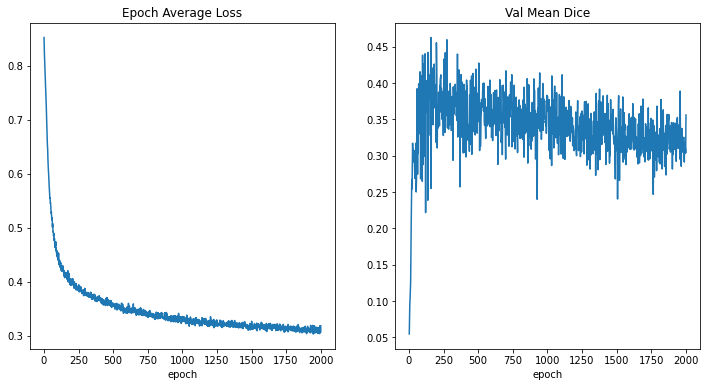

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

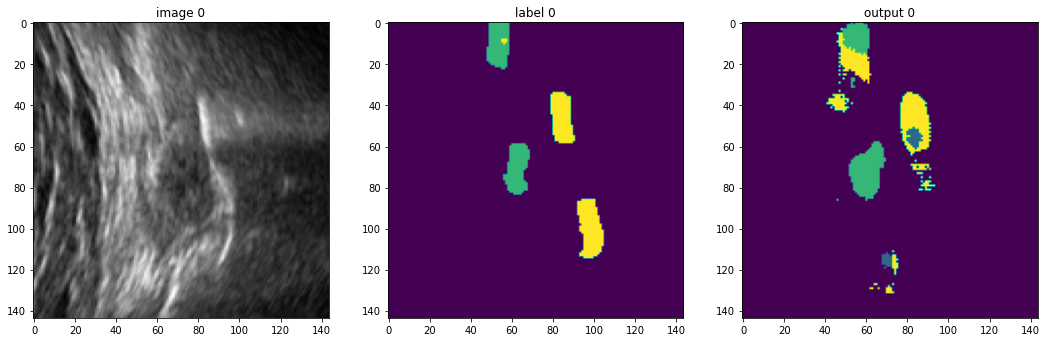

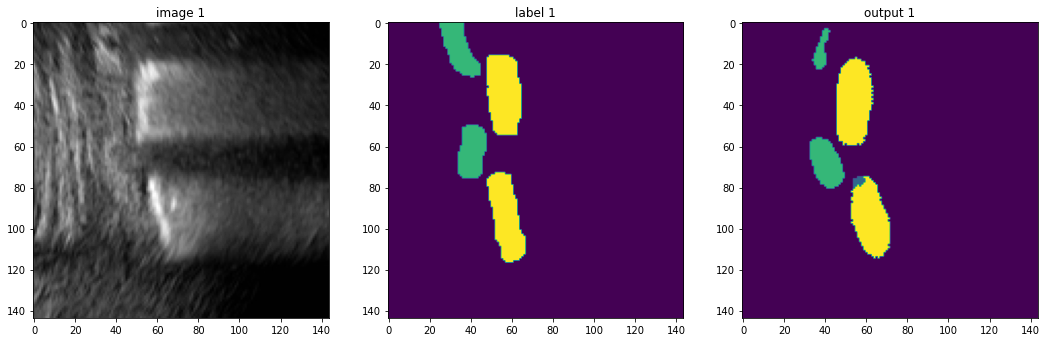

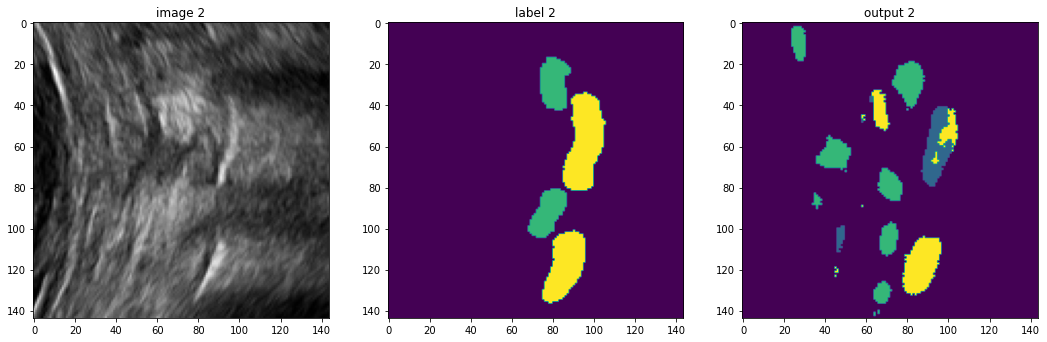

In [16]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (144, 144, 16)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 10], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 10])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 10])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [17]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=0)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=True, num_classes=4),
    AsDiscreted(keys="label", to_onehot=True, num_classes=4),
])

In [18]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (144, 144, 16)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.29819926619529724


## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)